# Spatial Statistics

Author: Franziska Niemeyer

Contact: franziska.niemeyer@helsinki.fi

Note: This notebook is partly based on [M. Emons, et al. 2025](https://doi.org/10.1093/nar/gkaf870).

**Topics in this notebook:**
1. Spatially variable genes
2. Functions to measure spatial variability in lattice data
3. Local indicators of spatial association (LISA)
4. Join count statistics

In spatial transcriptomics, the appropriate statistical framework depends on the data resolution. When analyzing single-cell coordinates or actual RNA molecule locations, the data resemble point pattern data, where the focus is on the spatial arrangement of individual cells or transcripts. In contrast, Visium and similar technologies measure gene expression in predefined spots arranged on a grid, which corresponds to lattice (areal) data. But also image-based ST data can be represented as (irregular) lattice data when considering the cell boundaries obtained from segmentations.

During this notebook, we will be focussing on lattice data, since most datasets can be seen as lattice data as long as you either have cell segmentations for your image-based data, or data already based on a regular lattice like Visium. We will be using a Visium mouse kidney dataset provided by 10X here.

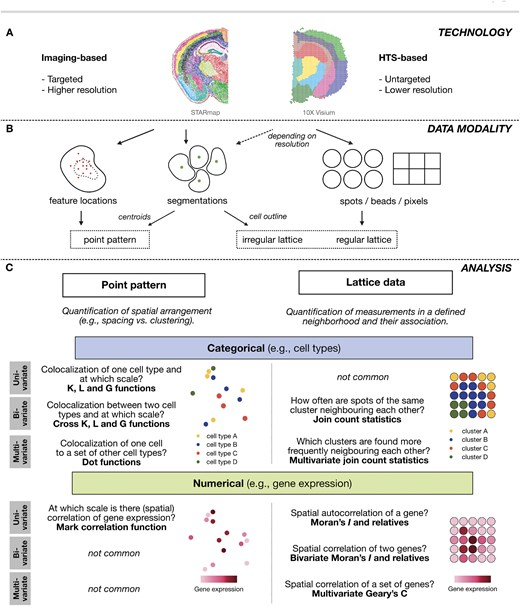

[M. Emons, et al. 2025](https://doi.org/10.1093/nar/gkaf870)

In [1]:
import numpy as np
import scanpy as sc
try:
    # Fix for known issue with squidpy - scanpy version incompatability
    from scanpy.plotting import _utils as sc_pl_utils
    if not hasattr(sc_pl_utils, "_set_default_colors_for_categorical_obs") and hasattr(
        sc_pl_utils, "set_default_colors_for_categorical_obs"
    ):
        sc_pl_utils._set_default_colors_for_categorical_obs = sc_pl_utils.set_default_colors_for_categorical_obs
except Exception:
    pass
import squidpy as sq
import pandas as pd

from scipy.stats import false_discovery_control

from esda.moran import Moran_Local, Moran_BV, Moran_Local_BV

from esda.lee import Spatial_Pearson, Spatial_Pearson_Local
from esda.geary_local_mv import Geary_Local_MV

from libpysal.cg import KDTree
from libpysal.weights import W, KNN

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

/opt/conda/envs/p13_spatial_stats/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/conda/envs/p13_spatial_stats/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/conda/envs/p13_spatial_stats/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .aut

In [2]:
# load the dataset
# adata = sq.datasets.visium("Visium_FFPE_Mouse_Kidney")   # use outside Noppe env only
path = "/home/jovyan/shared/day-04/data/Visium_FFPE_Mouse_Kidney"
adata = sc.read_visium(path)
adata.var_names_make_unique()

# normalise counts
adata.raw = adata.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata

AnnData object with n_obs × n_vars = 3124 × 19465
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

# Regular lattice and spatial weight matrix

Spot based data is collected along a regular spaced grid where all sample areas have the same size. Such a grid is also called a regular lattice. In more rigorous terms the data is a realisation of a random variable fixed along a lattice. The lattice does not have to be regular but in the scope of spot based data it is. Spot-based data is generated by a defined sampling strategy, whereas point pattern data is the result of a stochastic process (Zuur, Ieno, and Smith 2007).

The lattice is composed of individual spatial units
$D = \{A_1, A_2, ..., A_n\}$ where these units do not overlap $A_i \cap A_j = \emptyset \ \forall i \neq j$.

The data is then a random variable of the spatial unit along the lattice $Y_i = Y(A_i)$.

Most lattice data analysis techniques build on the concept of neighbours. Therefore, the spatial relationship can be modeled with e.g. a spatial weight matrix $W$. 
There are a lot of ways to define a spatial weight matrix $W$. It can for example be defined as a binary contiguity matrix where adjacent units are indicated by 1, and non-adjacent units as 0.

$
w_{ij} = 
\begin{cases}1 \text{ if } \ A_i \text{ and } A_j \text{ are adjacent } \\
0 \text{ otherwise
}\end{cases}
$ 

Other options to specify the weight matrix $W$ are mentioned in Zuur, Ieno, and Smith (2007).

In [3]:
# compute spatial neighborhood graph
sq.gr.spatial_neighbors(adata, n_neighs=6, coord_type="grid")

# remove unconnected spots
adata = adata[adata.obsp["spatial_connectivities"].sum(1).A1 > 0, :].copy()

# calculate spatial weights, here, every edge will get a weight of 1
spatial_weights = W.from_sparse(adata.obsp["spatial_connectivities"])

Let's display our calculated weights in it's most natural form - a spatial neighborhood graph. But first, we will crop our image to be able to better see the edges in our graph and to save some memory since this can be quite resource-intense.

In [4]:
xy = adata.obsm["spatial"]

x0, x1, y0, y1 = 8000, 15500, 8000, 16000
crop = (x0, y0, x1, y1)
print("crop_coord =", crop)

sf = adata.uns["spatial"]["Visium_FFPE_Mouse_Kidney"]["scalefactors"]
s = sf["tissue_hires_scalef"]
crop_hires = (x0*s, y0*s, x1*s, y1*s)
print("crop_coord_hires =", crop_hires)

crop_coord = (8000, 8000, 15500, 16000)
crop_coord_hires = (583.02664, 583.02664, 1129.614115, 1166.05328)


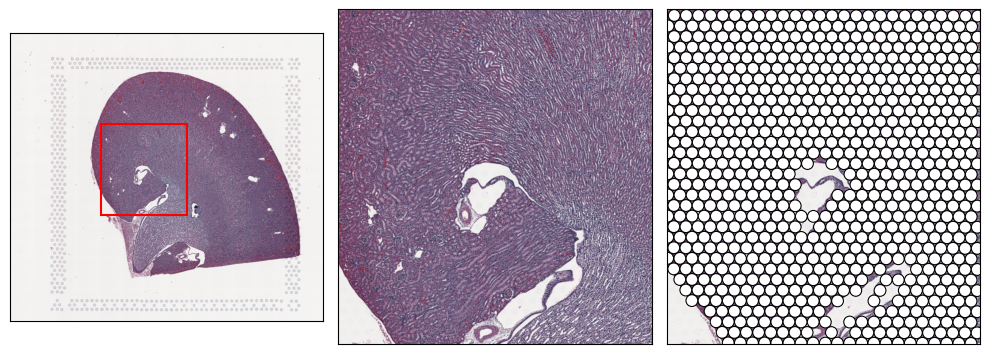

In [5]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 3, figsize=(10, 6))

sq.pl.spatial_scatter(
    adata,
    color=None,
    alpha=0.5,
    img_alpha=1,
    ax=ax[0],
)

# draw crop rectangle
x0, y0, x1, y1 = crop_hires
rect = Rectangle(
    (x0, y0),          # bottom-left corner
    x1 - x0,           # width
    y1 - y0,           # height
    linewidth=1.5,
    edgecolor="red",
    facecolor="none",
    zorder=10
)

# plot crop
sq.pl.spatial_scatter(
    adata,
    color=None,
    alpha=.5,
    img_alpha=1,
    crop_coord=crop,
    ax=ax[1]
)

# plot spot outlines
sq.pl.spatial_scatter(
    adata,
    size=1.3,
    color=None,
    alpha=.2,
    img_alpha=1,
    outline=True,
    outline_width=(.05,.01),
    crop_coord=crop,
    ax=ax[2]
)

ax[0].add_patch(rect)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)

plt.tight_layout()
plt.show()

Squidpy uses a slighly different order of the edge points in the crop so we will adapt it here quickly.

In [6]:
x0, y0, x1, y1 = crop
crop_sq = (min(x0, x1), max(x0, x1), min(y0, y1), max(y0, y1))
print("crop squidpy:", crop_sq)

crop squidpy: (8000, 15500, 8000, 16000)


Now we can visualize our neighborhood graph, also called connectivity graph. In addition, we can visualize it's weights for a given random index spot.

In [7]:
x0, y0, x1, y1 = crop  # (x0, y0, x1, y1)

xy = adata.obsm["spatial"]
inside = (
    (xy[:, 0] >= x0) & (xy[:, 0] <= x1) &
    (xy[:, 1] >= y0) & (xy[:, 1] <= y1)
)
idx_inside = np.where(inside)[0]

# random spot inside crop
np.random.seed(42)
idx = int(np.random.choice(idx_inside))
print("chosen spot index:", idx)

chosen spot index: 476


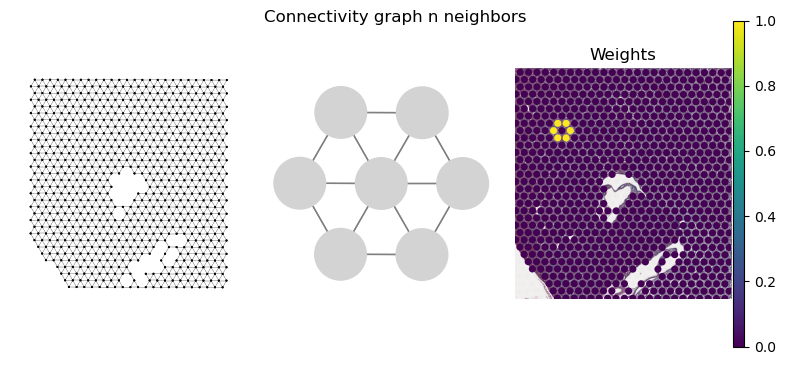

In [8]:
x0, x1, y0, y1 = crop_sq
xy = adata.obsm["spatial"]

mask = (xy[:, 0] >= x0) & (xy[:, 0] <= x1) & (xy[:, 1] >= y0) & (xy[:, 1] <= y1)

i = np.where(mask)[0]

A = adata.obsp["spatial_connectivities"].tocsr()
A_sub = A[i][:, i].tocsr()

adata_crop = adata[i].copy()
adata_crop.obsp["spatial_connectivities"] = A_sub
if "spatial_distances" in adata.obsp:
    adata_crop.obsp["spatial_distances"] = adata.obsp["spatial_distances"].tocsr()[i][:, i].tocsr()

fig, ax = plt.subplots(1, 3, figsize=(8, 4), layout="tight")
sq.pl.spatial_scatter(
    adata_crop,
    connectivity_key="spatial_connectivities",
    size=1.0,
    edges_color="black",
    edges_width=0.1,
    shape=None,
    library_id="spatial",
    ax=ax[0],
    fig=fig,
)
ax[0].set_axis_off()
fig.suptitle("Connectivity graph n neighbors", y=0.9)

_, i = adata.obsp["spatial_connectivities"][idx, :].nonzero()
i = np.append(i, idx)
sq.pl.spatial_scatter(
    adata[i, :],
    connectivity_key="spatial_connectivities",
    img=False,
    ax=ax[1],
    na_color="lightgrey",
)
ax[1].set_axis_off()

A = adata.obsp["spatial_connectivities"].tocsr()

weights = A[idx].toarray().ravel()
adata.obs["weights_from_idx0"] = weights

sq.pl.spatial_scatter(
    adata,
    color="weights_from_idx0",
    title="Weights",
    cmap="viridis",
    size=1.3,
    crop_coord=crop,
    ax=ax[2]
)
ax[2].set_axis_off()

plt.show()

Other ways of defining the neighborhood graph are for example by defining a **radius** around our index spot. This is particularly useful for irregular lattice data like segmented cells or point pattern data like transcript counts or cell centroids. But one must be careful when using the radius to define the neighborhood graph, since areas with non-uniform cell-density (i.e. areas with very high density next to areas with low cell density) will result in vastly different graph connectivities between these areas. In those cases, different transformations can be applied to the matrix to account for these differences.

In [9]:
sq.gr.spatial_neighbors(adata, radius=600, coord_type="generic", key_added="radius")
adata

AnnData object with n_obs × n_vars = 3123 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'weights_from_idx0'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'spatial_neighbors', 'radius_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances', 'radius_connectivities', 'radius_distances'

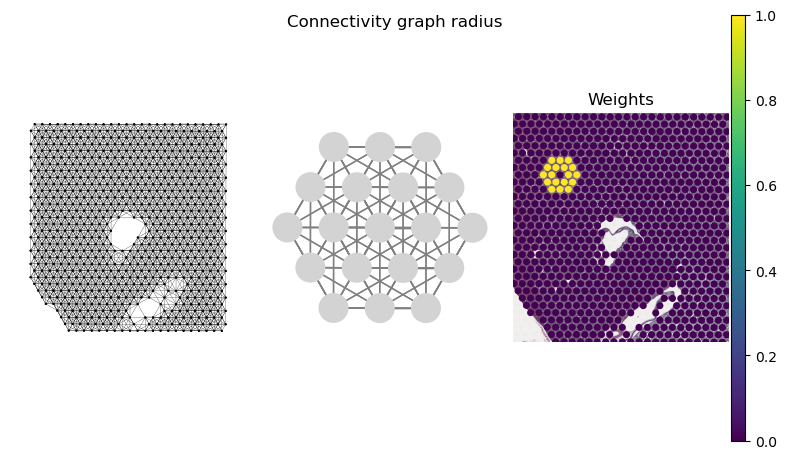

In [10]:
x0, x1, y0, y1 = crop_sq
xy = adata.obsm["spatial"]

mask = (xy[:, 0] >= x0) & (xy[:, 0] <= x1) & (xy[:, 1] >= y0) & (xy[:, 1] <= y1)

i = np.where(mask)[0]

A = adata.obsp["radius_connectivities"].tocsr()
A_sub = A[i][:, i].tocsr()

adata_crop = adata[i].copy()
adata_crop.obsp["radius_connectivities"] = A_sub
if "radius_distances" in adata.obsp:
    adata_crop.obsp["radius_distances"] = adata.obsp["radius_distances"].tocsr()[i][:, i].tocsr()

fig, ax = plt.subplots(1, 3, figsize=(8, 5), layout="tight")
sq.pl.spatial_scatter(
    adata_crop,
    connectivity_key="radius_connectivities",
    size=1.0,
    edges_color="black",
    edges_width=0.1,
    shape=None,
    library_id="spatial",
    ax=ax[0],
    fig=fig,
)
ax[0].set_axis_off()
fig.suptitle("Connectivity graph radius", y=0.9)

_, i = adata.obsp["radius_connectivities"][idx, :].nonzero()
i = np.append(i, idx)
sq.pl.spatial_scatter(
    adata[i, :],
    connectivity_key="radius_connectivities",
    img=False,
    ax=ax[1],
    na_color="lightgrey",
)
ax[1].set_axis_off()

A = adata.obsp["radius_connectivities"].tocsr()

weights = A[idx].toarray().ravel()
adata.obs["weights_radius_from_idx0"] = weights

sq.pl.spatial_scatter(
    adata,
    color="weights_radius_from_idx0",
    title="Weights",
    cmap="viridis",
    size=1.3,
    crop_coord=crop,
    ax=ax[2]
)
ax[2].set_axis_off()

plt.show()

There are now also different transformations that can be applied to our adjacency matrix / connectivity graph to account for the distance to neighbors and for the node/cell/spot density of the given area. The **cosine transformation** is a very practical transformation if we work with cell segmentations or with direct transcript (point pattern) data. It rescales each edge weight by the geometrix mean of the node's degrees, so that dones with many neighbors (high degree) get downweighted, whereas nodes with few neighbors get relatively upweighted. Therefore, the matrix becomes symmetric and degree-normalized. The cosine transformation is defined as follows:

$$A_{ij} = \frac{A_{ij}}{\sqrt{d_i d_j}}$$

where $d_i = \sum_j{A_{ij}}$.

In [11]:
sq.gr.spatial_neighbors(adata, radius=600, coord_type="generic", transform="cosine", key_added="radius_cosine")
adata

AnnData object with n_obs × n_vars = 3123 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'weights_from_idx0', 'weights_radius_from_idx0'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'spatial_neighbors', 'radius_neighbors', 'radius_cosine_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances', 'radius_connectivities', 'radius_distances', 'radius_cosine_connectivities', 'radius_cosine_distances'

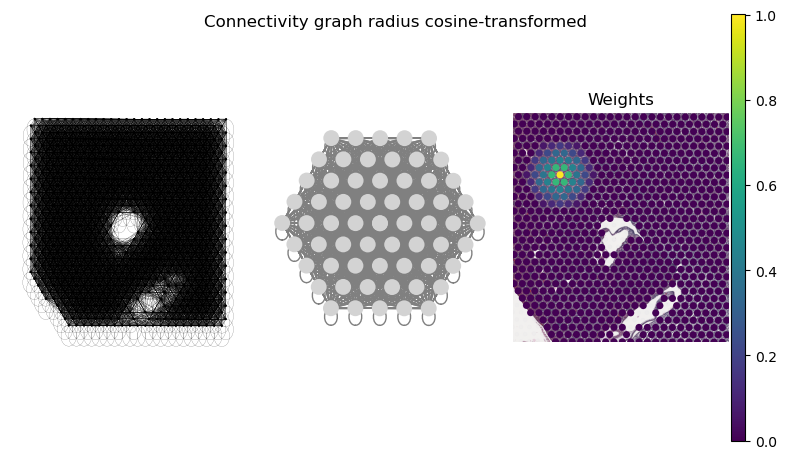

In [12]:
x0, x1, y0, y1 = crop_sq
xy = adata.obsm["spatial"]

mask = (xy[:, 0] >= x0) & (xy[:, 0] <= x1) & (xy[:, 1] >= y0) & (xy[:, 1] <= y1)

i = np.where(mask)[0]

A = adata.obsp["radius_cosine_connectivities"].tocsr()
A_sub = A[i][:, i].tocsr()

adata_crop = adata[i].copy()
adata_crop.obsp["radius_cosine_connectivities"] = A_sub
if "radius_cosine_distances" in adata.obsp:
    adata_crop.obsp["radius_cosine_distances"] = adata.obsp["radius_cosine_distances"].tocsr()[i][:, i].tocsr()

fig, ax = plt.subplots(1, 3, figsize=(8, 5), layout="tight")
sq.pl.spatial_scatter(
    adata_crop,
    connectivity_key="radius_cosine_connectivities",
    size=1.0,
    edges_color="black",
    edges_width=0.1,
    shape=None,
    library_id="spatial",
    ax=ax[0],
    fig=fig,
)
ax[0].set_axis_off()
fig.suptitle("Connectivity graph radius cosine-transformed", y=0.9)

_, i = adata.obsp["radius_cosine_connectivities"][idx, :].nonzero()
i = np.append(i, idx)
sq.pl.spatial_scatter(
    adata[i, :],
    connectivity_key="radius_cosine_connectivities",
    img=False,
    ax=ax[1],
    na_color="lightgrey",
)
ax[1].set_axis_off()

A = adata.obsp["radius_cosine_connectivities"].tocsr()

weights = A[idx].toarray().ravel()
adata.obs["weights_radius_from_idx0"] = weights

sq.pl.spatial_scatter(
    adata,
    color="weights_radius_from_idx0",
    title="Weights",
    cmap="viridis",
    size=1.3,
    crop_coord=crop,
    ax=ax[2]
)
ax[2].set_axis_off()

plt.show()

# Spatial autocorrelation

The first law of geography tells us: "Everything is related to everything else, but near things are more related than distant things." (Waldo R. Tobler)

Spatial autocorrelation describes the dependency between physical distance and a variable you are measuring. The concept of spatial autocorrelation provides the basis for all the following statistics we will look at in this practical.

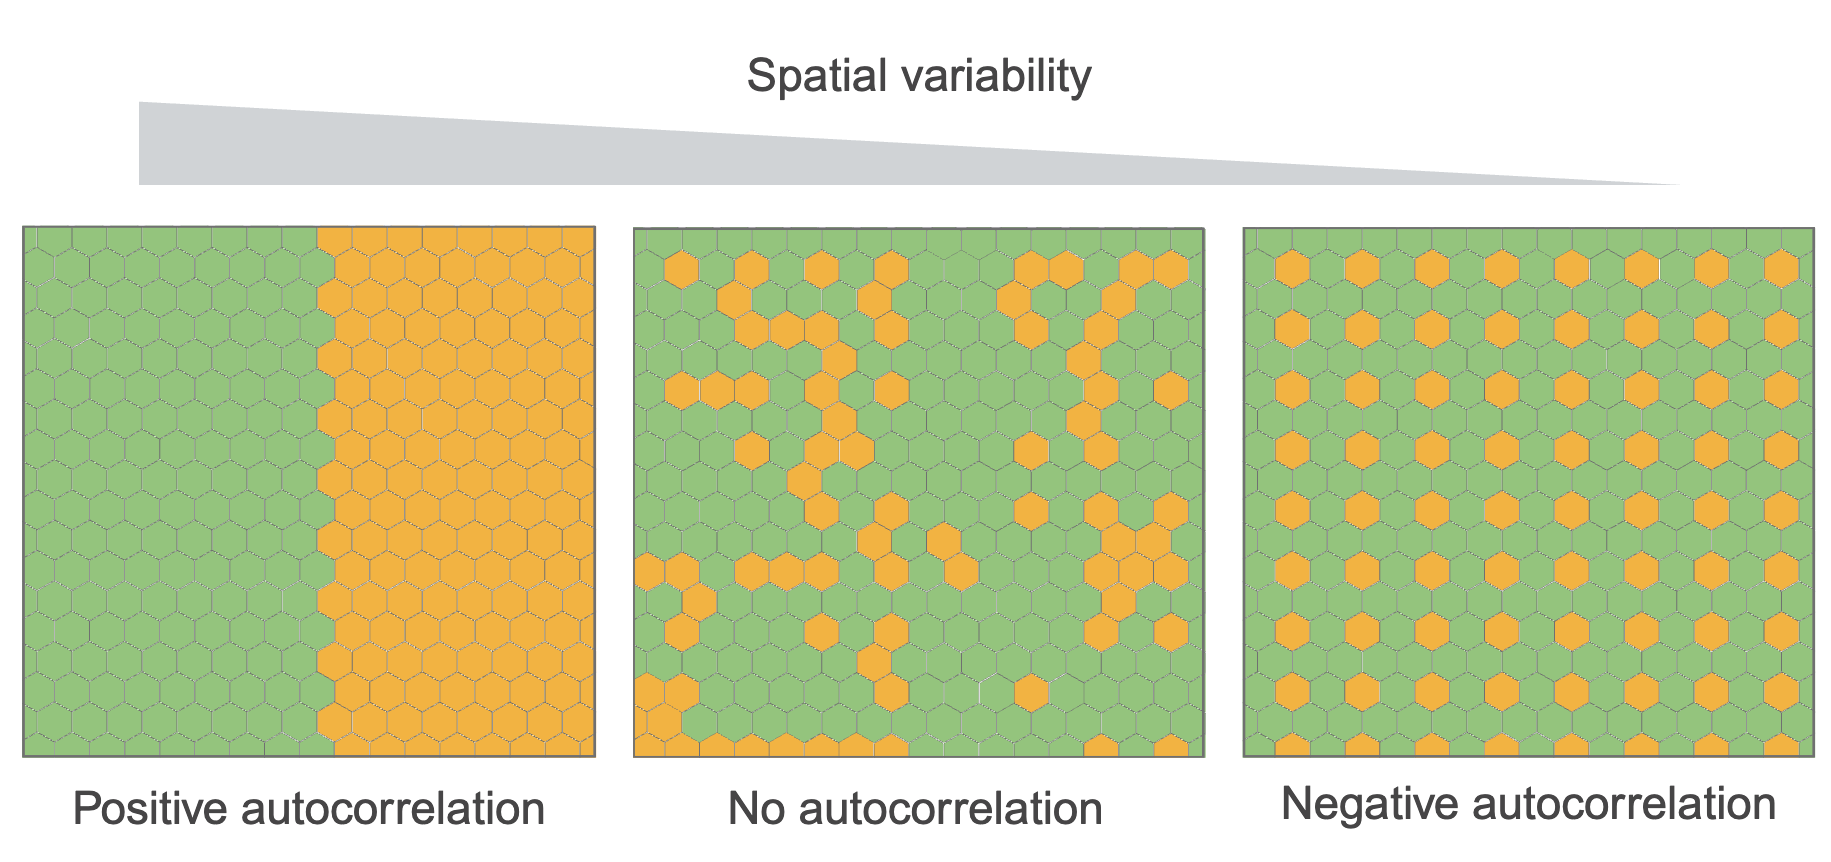

<div style="
  padding: 12px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>

<div>
    If the spatial autocorrelation is strongly positive, which statement must be true?
    <ol>
        <li>The gene is highly expressed</li>
        <li>High and low values cluster spatially</li>
        <li>The gene defines a cell type</li>
        <li>The gene is differentially expressed</li>
    </ol>
</div>
<details style="
margin-top: 10px;
padding: 8px 10px;
background: rgba(0,0,0,0.05);
border-radius: 8px;
">
<summary style="cursor: pointer; font-weight: 600;">
  🔎 Click to reveal answer
</summary>
<div style="margin-top: 8px;">
  Number 2 is true!
</div>
</details>
</div>

## Global Univariate Moran's $I$

In the following, we are going to explore how the univariate Moran's $I$ as a measure of spatial autocorrelation is calculated.

We choose two genes of interest here. In this example we chose Slc5a12 (solute carrier family 5, member 12) and Calr (calreticulin). For all the following analyses, we will use the n-neighbors definition of our spatial connectivities graph for simplicity.

In [13]:
# predefine genes
features = ["Slc5a12", "Calr"]

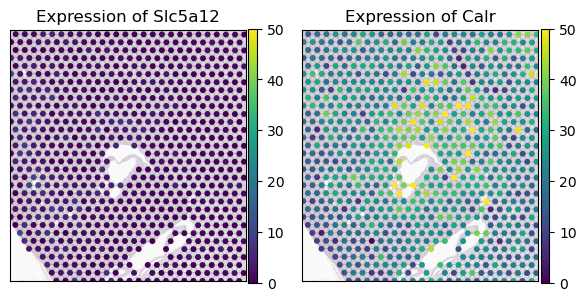

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout="tight")

sq.pl.spatial_scatter(
    adata,
    color=features[0],
    cmap="viridis",
    size=1.0,
    connectivity_key="spatial_connectivities",
    edges_color="black",
    edges_width=0.05,
    library_id="Visium_FFPE_Mouse_Kidney",
    title=f"Expression of {features[0]}",
    crop_coord=crop,
    img_alpha=.3,
    vmin=0, vmax=50,
    ax=ax[0],
)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)

sq.pl.spatial_scatter(
    adata,
    color=features[1],
    cmap="viridis",
    size=1.0,
    connectivity_key="spatial_connectivities",
    edges_color="black",
    edges_width=0.05,
    library_id="Visium_FFPE_Mouse_Kidney",
    title=f"Expression of {features[1]}",
    crop_coord=crop,
    img_alpha=.3,
    vmin=0, vmax=50,
    ax=ax[1],
)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)

plt.show()

Let's focus on the expression of Calr first, so we are in the **univariate case** of analysing **numerical data** now.

In [15]:
g = features[1]

x = adata[:, g].X
x = x.toarray().ravel().astype(float) if hasattr(x, "toarray") else np.asarray(x).ravel().astype(float)

# z-score
z = (x - x.mean()) / (x.std(ddof=1) + 1e-12)

# row-standardize weights (rows sum to 1)
spatial_weights.transform = "R"

ml = Moran_Local(z, spatial_weights, permutations=499)

# local Moran's I and p-values
adata.obs[f"local_moran_{g}"] = ml.Is
adata.obs[f"local_moran_{g}_p_sim"] = ml.p_sim

We can now calculate the z-score of our variable, so the (scaled) distance from the mean expression in both directions.

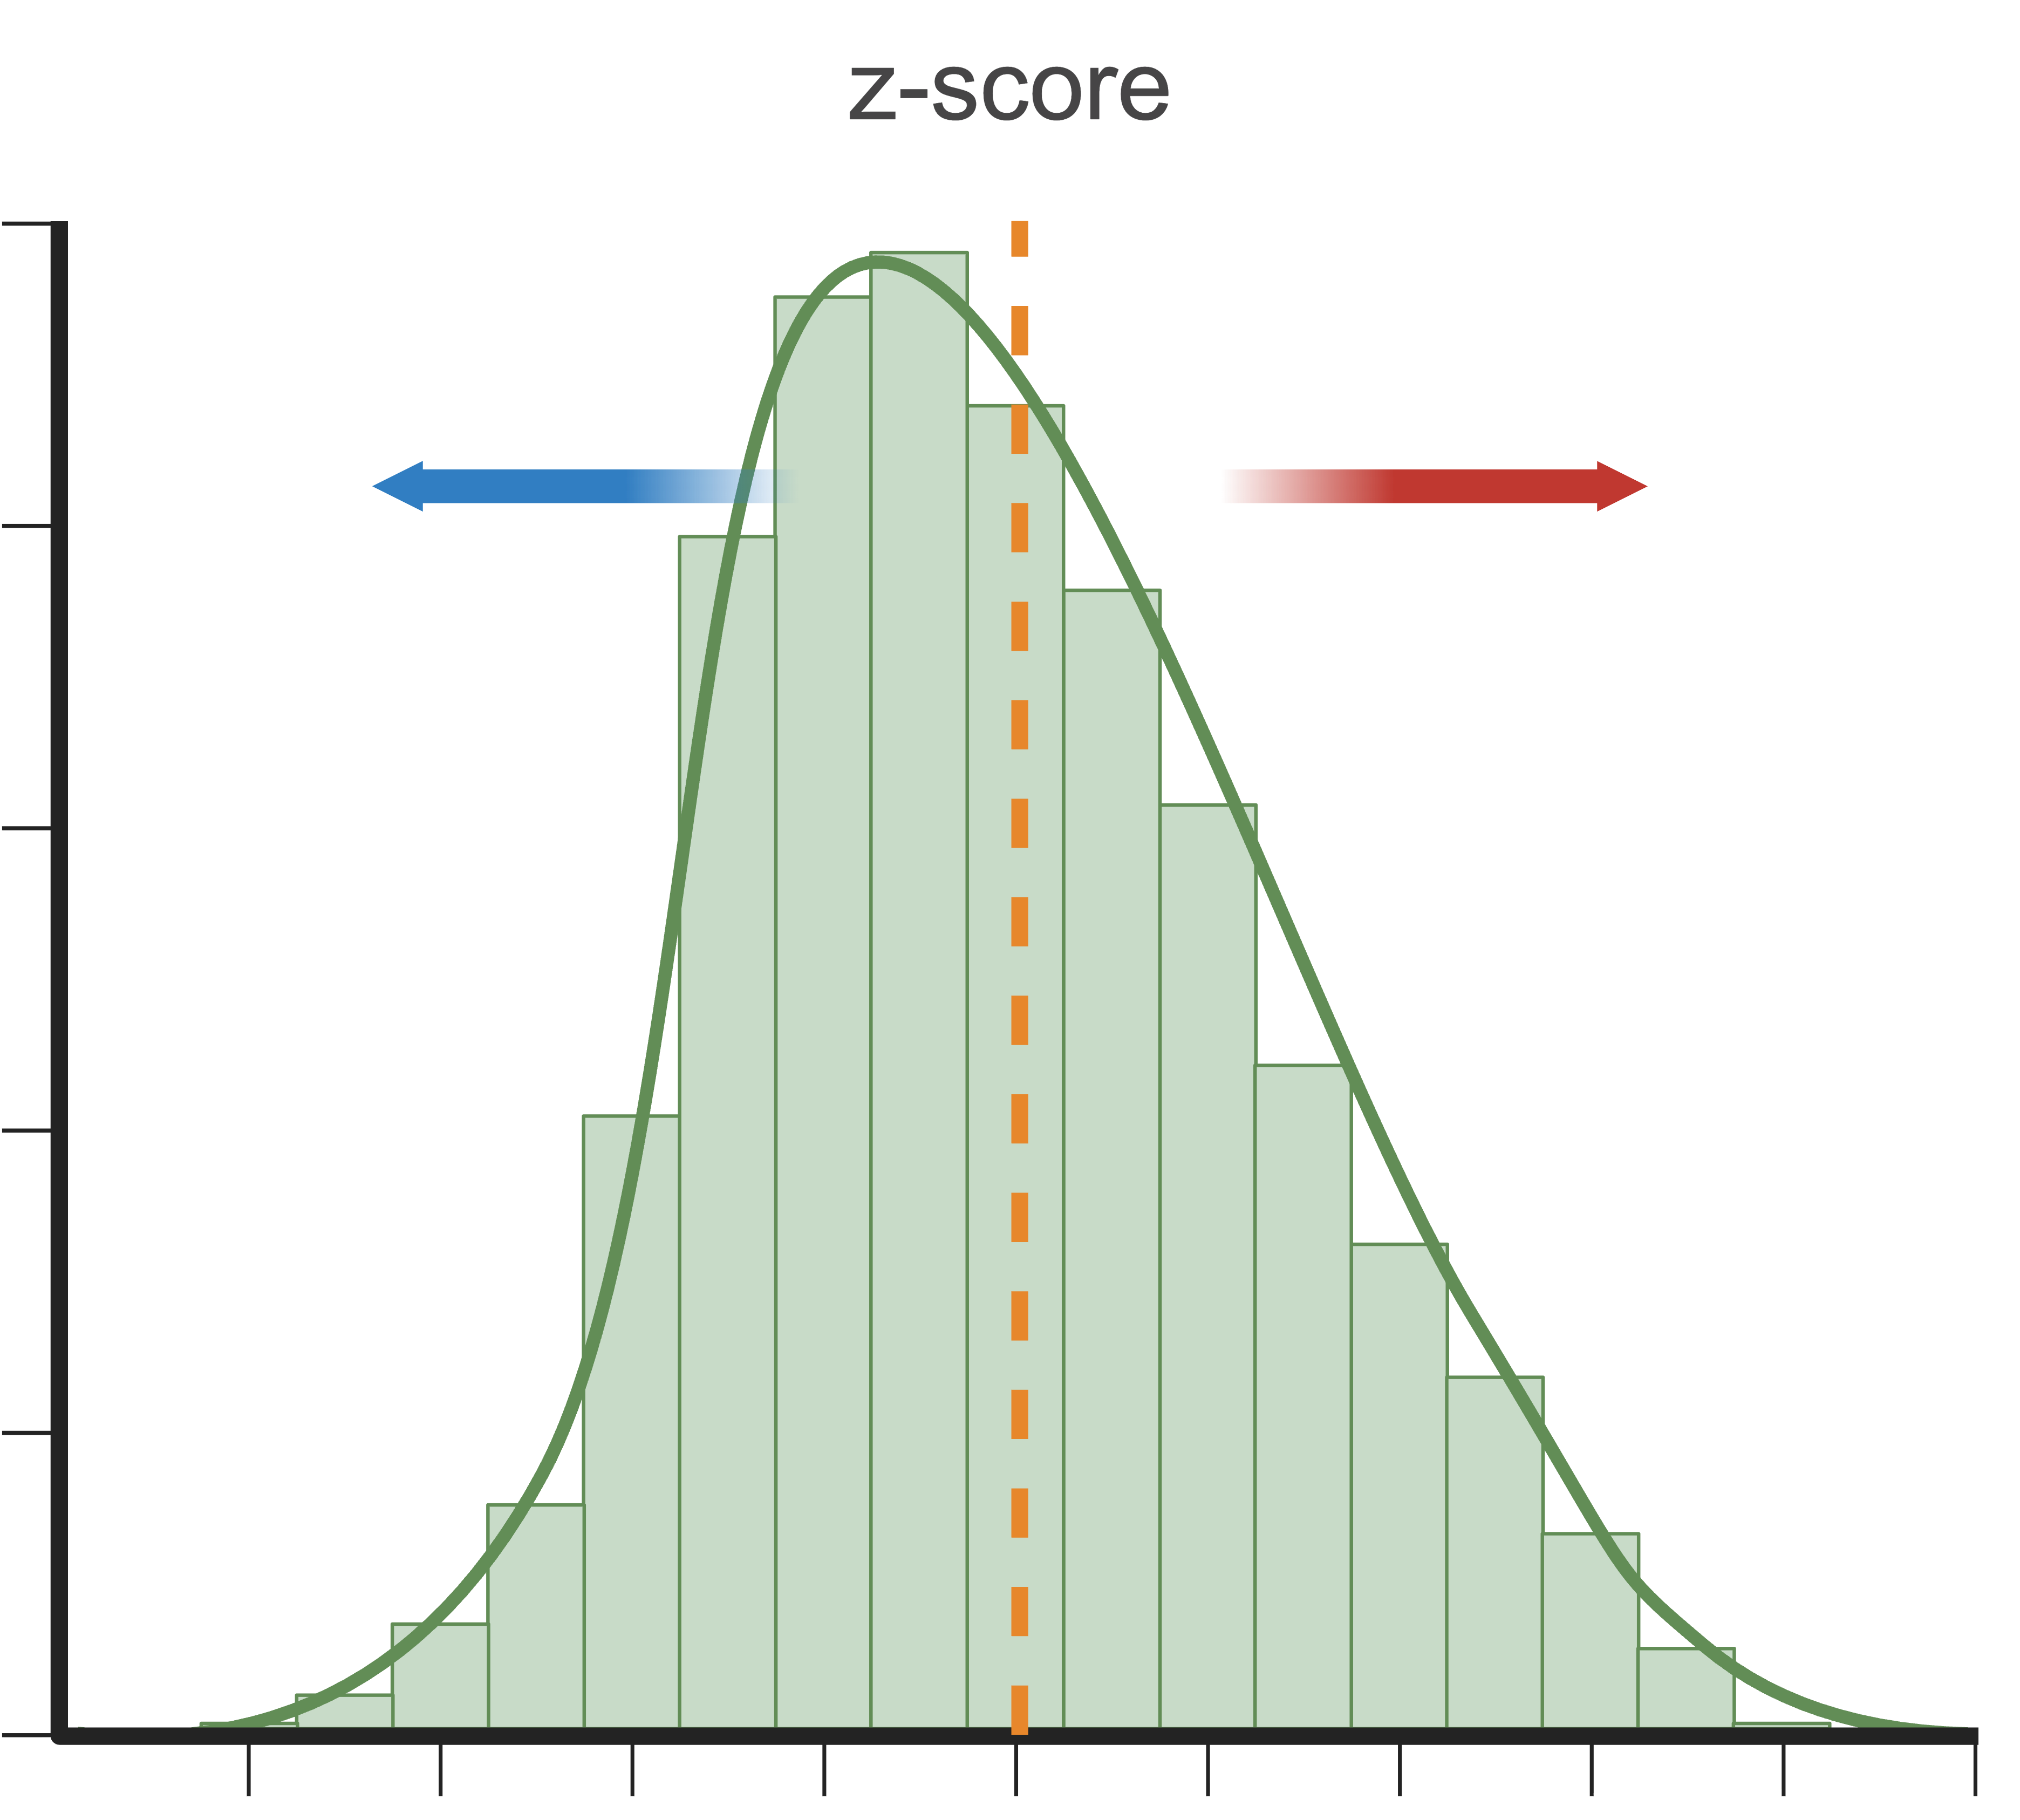

In [16]:
from libpysal.weights.spatial_lag import lag_spatial
from matplotlib.colors import TwoSlopeNorm

x = adata[:, g].X
x = x.toarray().ravel().astype(float) if hasattr(x, "toarray") else np.asarray(x).ravel().astype(float)

# z-score
z = (x - x.mean()) / (x.std(ddof=1) + 1e-12)

z_key  = f"{g}_z"
adata.obs[z_key] = z

Let's plot our z-scores spatially.

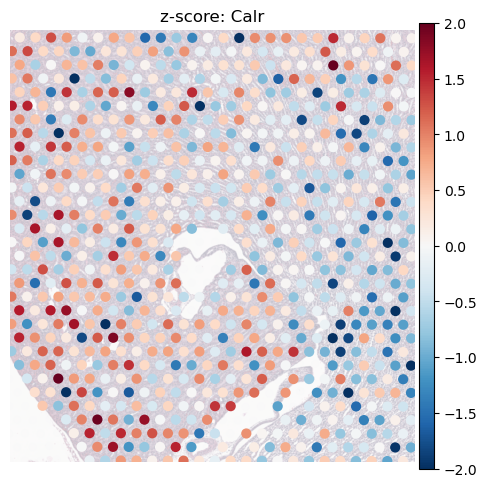

In [17]:
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(
    vmin=-2,
    vcenter=0,
    vmax=2
)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
sq.pl.spatial_scatter(
    adata,
    color=z_key,
    cmap='RdBu_r',
    norm=norm,
    size=1,
    library_id="Visium_FFPE_Mouse_Kidney",
    crop_coord=crop,
    img_alpha=.3,
    ax=ax,
)
ax.set_axis_off()
ax.set_title(f"z-score: {g}")
plt.show()

To make this a bit more graspable, let's just choose one spot and visualize the z-scores of it's neighbors.

In [18]:
xy = adata.obsm["spatial"]

# mask of spots inside crop
x0, y0, x1, y1 = crop
inside = (
    (xy[:, 0] >= x0) & (xy[:, 0] <= x1) &
    (xy[:, 1] >= y0) & (xy[:, 1] <= y1)
)
i = int(idx)

# neighbors of chosen spot
nbrs = spatial_weights.neighbors[idx]

# neighbors inside crop
nbrs_in = [j for j in nbrs if inside[j]]

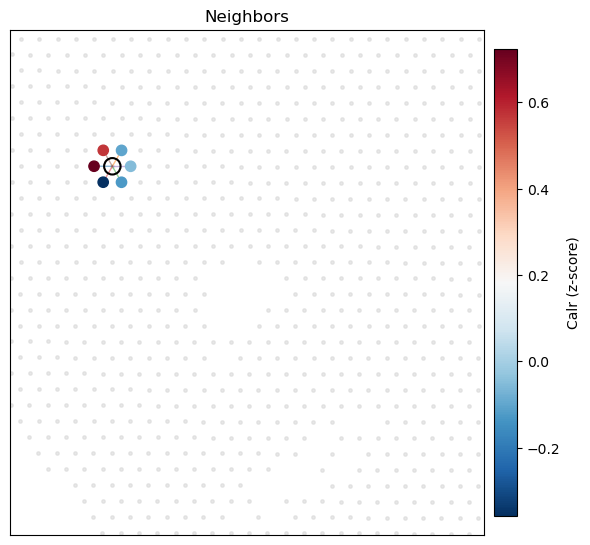

In [19]:
# neighbor values for the chosen spot
vals_in = z[nbrs_in]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="tight")

ax.scatter(
    xy[inside, 0],
    xy[inside, 1],
    s=6,
    alpha=0.5,
    color="lightgray"
)

# neighbors: colored by z(g)
scatter = ax.scatter(
    xy[nbrs_in, 0],
    xy[nbrs_in, 1],
    c=vals_in,
    s=55,
    cmap='RdBu_r',
    zorder=2
)

# index spot
ax.scatter(
    xy[i, 0],
    xy[i, 1],
    s=140,
    facecolors="none",
    edgecolors="black",
    linewidths=1.5,
    zorder=3
)

# edges to neighbors
for j in nbrs_in:
    ax.plot(
        [xy[i, 0], xy[j, 0]],
        [xy[i, 1], xy[j, 1]],
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Neighbors")

fig.colorbar(
    scatter,
    ax=ax,
    fraction=0.046,
    pad=0.02,
    label=f"{g} (z-score)"
)

plt.show()

Now we can calculate the average z-score of our neighboring spots, basically smoothing the expression values around our index spot. This average is called **spatial lag**.

In [20]:
# lag is the neighbor average
wz = lag_spatial(spatial_weights, z)

z_key  = f"{g}_z"
lag_key = f"lag_{g}_z"
adata.obs[z_key] = z
adata.obs[lag_key] = wz

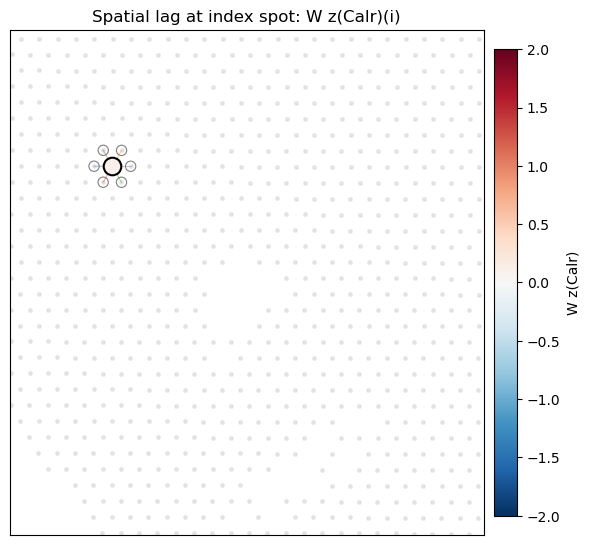

In [21]:
fig, ax = plt.subplots(figsize=(6, 6), layout="tight")

# background: all spots in crop (faint, neutral)
ax.scatter(
    xy[inside, 0],
    xy[inside, 1],
    s=6,
    alpha=0.5,
    color="lightgray",
    zorder=1
)

# index spot ONLY: colored by spatial lag
lag_i = adata.obs[f"lag_{g}_z"].iloc[i]

scatter = ax.scatter(
    xy[i, 0],
    xy[i, 1],
    s=160,
    c=[lag_i],
    cmap='RdBu_r',
    norm=norm,
    edgecolors="black",
    linewidths=1.5,
    zorder=3
)

# optional: outline neighbors (context only, no color)
nbrs = spatial_weights.neighbors[i]
nbrs_in = [j for j in nbrs if inside[j]]

ax.scatter(
    xy[nbrs_in, 0],
    xy[nbrs_in, 1],
    s=55,
    facecolors="none",
    edgecolors="gray",
    linewidths=0.8,
    zorder=2
)

# optional: draw edges to neighbors
for j in nbrs_in:
    ax.plot(
        [xy[i, 0], xy[j, 0]],
        [xy[i, 1], xy[j, 1]],
        linewidth=0.8,
        alpha=0.4,
        zorder=2
    )

# formatting
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Spatial lag at index spot: W z({g})(i)")

# colorbar refers ONLY to lag values
fig.colorbar(
    scatter,
    ax=ax,
    fraction=0.046,
    pad=0.02,
    label=f"W z({g})"
)

plt.show()

We can now also plot the spatial lag for all spots.

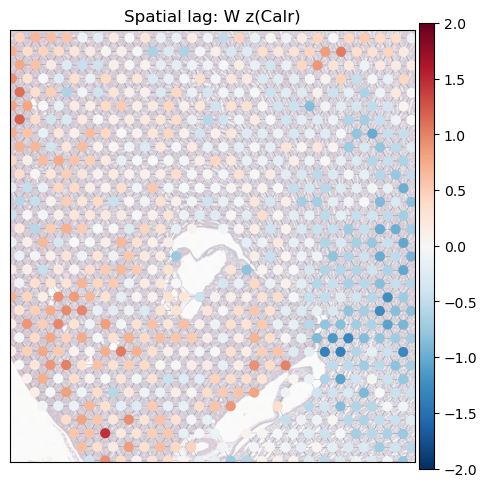

In [22]:
lag_key = f"lag_{g}_z"

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")

sq.pl.spatial_scatter(
    adata,
    color=lag_key,
    cmap='RdBu_r',
    norm=norm,
    size=1.0,
    connectivity_key="spatial_connectivities",
    edges_color="black",
    edges_width=0.05,
    library_id="Visium_FFPE_Mouse_Kidney",
    title=f"Spatial lag: W z({g})",
    crop_coord=crop,
    img_alpha=.3,
    ax=ax,
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xlabel(None)

plt.show()

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🪞 Reflection</div>
  <div>
    Now that you have computed the spatial lag, take a moment to think:
    <ul>
      <li>What does a high spatial lag value actually represent?</li>
      <li>Can a spot have low expression but high spatial lag? What would that mean biologically?</li>
      <li>How does the definition of the spatial weights matrix (kNN vs radius) influence the lag values?</li>
    </ul>
    Spatial lag is not the original signal — it is a spatially smoothed version of it.
  </div>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
      <p><strong>1. What does a high spatial lag value represent?</strong><br>
      It represents that the neighboring spots have high expression values. The spatial lag is a weighted average of neighbors, so a high lag means the local neighborhood is strongly expressing the gene.</p>
      <p><strong>2. Can a spot have low expression but high spatial lag?</strong><br>
      Yes. This means the spot itself has low expression, but it is surrounded by high-expressing neighbors. Biologically, this may indicate a boundary region or transitional zone between tissue domains.</p>
      <p><strong>3. How does the spatial weights matrix influence lag values?</strong><br>
      The weights matrix defines which neighbors contribute and how strongly. A small kNN graph captures very local structure, while a larger radius or higher k smooths over broader regions, producing more global lag patterns.</p>
  </details>
</div>

### Local Indicators of Spatial Association (LISA)

We can now **plot the z-score of every spot against it's spatial lag** to get a feeling for how a given spot's expression value behaves in comarision to it's neighbors. Visualizing this for all spots gives us a so called LISA quadrant map, which is divided into four quadrants, split by the zero-axis. A LISA map can be used to identify spatial clusters and outliers.

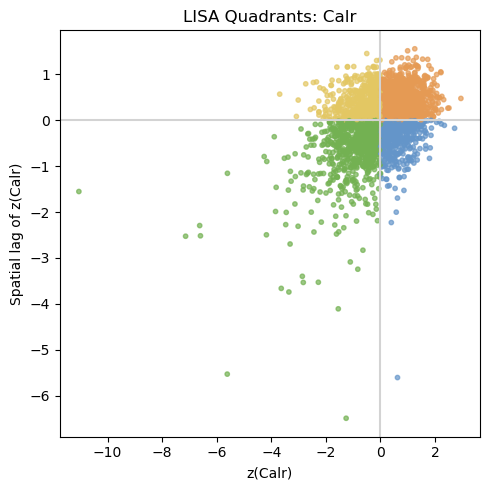

In [23]:
quad = np.full(len(z), "NS", dtype=object)
quad[(z > 0) & (wz > 0)] = "HH"
quad[(z < 0) & (wz < 0)] = "LL"
quad[(z > 0) & (wz < 0)] = "HL"
quad[(z < 0) & (wz > 0)] = "LH"

colors = {
    "HH": "#e59a54",
    "LL": "#73b152",
    "HL": "#6495c9",
    "LH": "#e3c763",
    "NS": "lightgray"
}

point_colors = [colors[q] for q in quad]

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
ax.scatter(z, wz, s=10, c=point_colors, alpha=0.7)

ax.axhline(0, lw=1.5, color='lightgray')
ax.axvline(0, lw=1.5, color='lightgray')

ax.set_xlabel(f"z({g})")
ax.set_ylabel(f"Spatial lag of z({g})")
ax.set_title(f"LISA Quadrants: {g}")

plt.show()

This plot can also answer the question: Do high values tend to sit next to high values (and low next to low)? We can quantify this directional question in a single summary statistic - the **global univariate Moran's $I$**. It basically measures the slope through the origin of our LISA map, or in other words, it gives us a measure of the global spatial autocorrelation of our given gene!

In [24]:
I_uni = (z @ wz) / (z @ z)
print("Global univariate Moran's I:", I_uni)

Global univariate Moran's I: 0.265930573090755


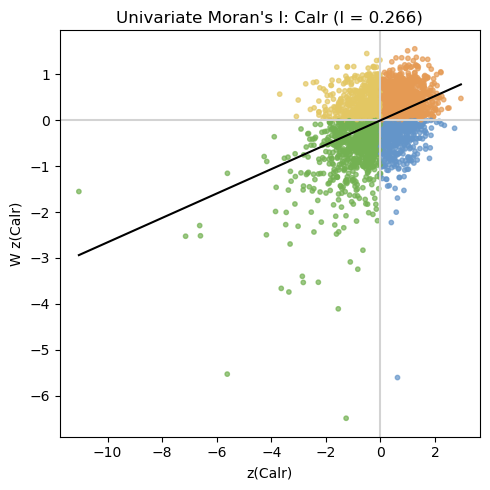

In [25]:
quad = np.full(len(z), "NS", dtype=object)
quad[(z > 0) & (wz > 0)] = "HH"
quad[(z < 0) & (wz < 0)] = "LL"
quad[(z > 0) & (wz < 0)] = "HL"
quad[(z < 0) & (wz > 0)] = "LH"

colors = {
    "HH": "#e59a54",
    "LL": "#73b152",
    "HL": "#6495c9",
    "LH": "#e3c763",
    "NS": "lightgray"
}

point_colors = [colors[q] for q in quad]

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
ax.scatter(z, wz, s=10, c=point_colors, alpha=0.7)

ax.axhline(0, lw=1.5, color='lightgray')
ax.axvline(0, lw=1.5, color='lightgray')

xs = np.linspace(z.min(), z.max(), 200)
ax.plot(xs, I_uni * xs, lw=1.5, color='black')

ax.set_xlabel(f"z({g})")
ax.set_ylabel(f"Spatial lag of z({g})")
ax.set_ylabel(f"W z({g})")
ax.set_title(f"Univariate Moran's I: {g} (I = {I_uni:.3f})")

plt.show()

Let's visualize the LISA quadrants spatially.

In [26]:
quad_key = f"quad"
adata.obs[quad_key] = pd.Categorical(quad, categories=["HH", "HL", "LH", "LL", "NS"], ordered=True)

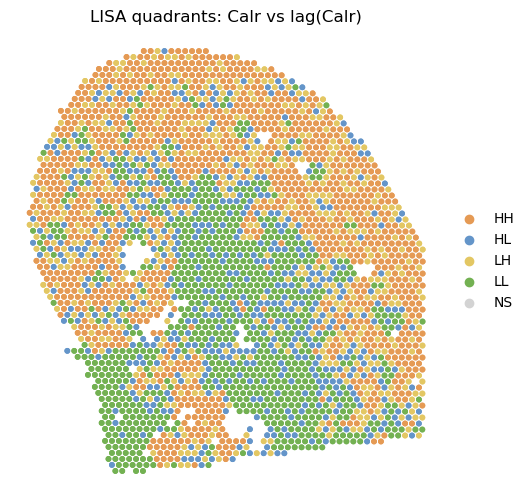

In [27]:
cmap_quads = ListedColormap(["#e59a54", "#6495c9", "#e3c763", "#73b152", "lightgrey"])  # HH, HL, LH, LL, NS

fig, ax = plt.subplots(figsize=(6, 6))
sq.pl.spatial_scatter(
    adata,
    color=quad_key,
    palette=cmap_quads,
    shape=None,
    library_id="spatial",
    title=f"LISA quadrants: {features[1]} vs lag({features[1]})",
    ax=ax,
    size=40,
)
ax.set_axis_off()
plt.show()

We can calculate the Moran's $I$ statistic for every gene in our dataset, which gives us a measure for the spatial variability / autocorrelation of all the genes in our dataset. Let's simply use the squidpy implementation of the Moran's $I$ for this. You can specify the connectivity graph to be used with the ``connectivity_key`` parameter. Go ahead and try the different graphs!

In [28]:
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names, connectivity_key='spatial_connectivities')

Squidpy also kindly provides p-values and a false discovery rate for our calculated Moran's $I$. They are calculated using a random permutation test. Let's have a look at the genes with the largest spatial autocorrelation.

In [29]:
adata.uns["moranI"].head()

I  pval_norm  var_norm  pval_norm_fdr_bh
Aldob    0.927159        0.0  0.000113               NaN
Gpx3     0.926287        0.0  0.000113               NaN
Slc34a1  0.925744        0.0  0.000113               NaN
Miox     0.900209        0.0  0.000113               NaN
Cryab    0.894734        0.0  0.000113               NaN

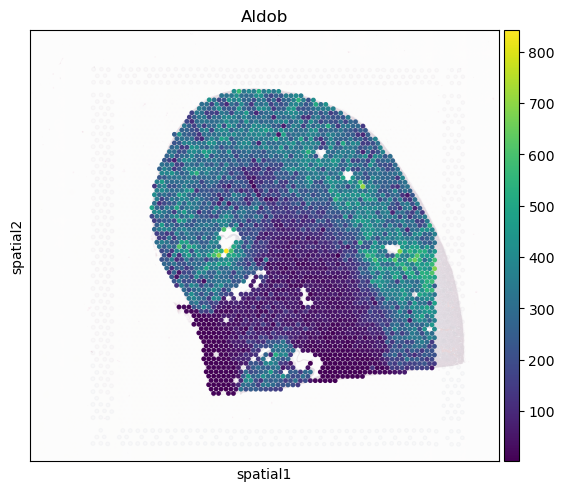

In [30]:
sq.pl.spatial_scatter(
    adata,
    size=1.5,
    color='Aldob',
    alpha=1,
    img_alpha=.2,
)

We can also take a look at a gene with a medium autocorrelation.

In [31]:
adata.uns["moranI"].iloc[1500]

I                   0.282422
pval_norm           0.000000
var_norm            0.000113
pval_norm_fdr_bh         NaN
Name: Lsm6, dtype: float64

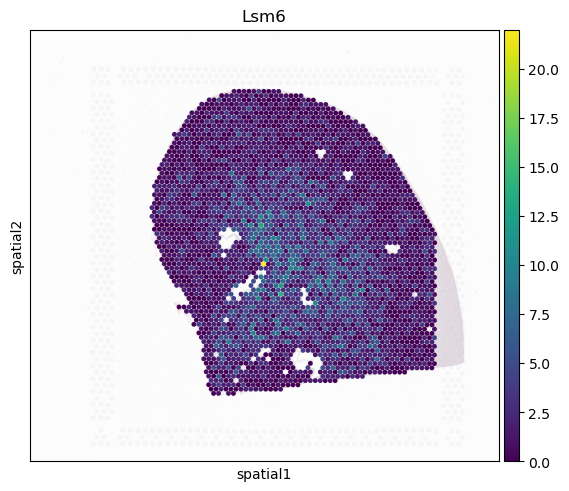

In [32]:
sq.pl.spatial_scatter(
    adata,
    size=1.5,
    color='Lsm6',
    alpha=1,
    img_alpha=.2,
)

And one with a low spatial autocorrelation (NaN because squidpy's implementation doesn't allow negative values).

In [33]:
adata.uns["moranI"].tail()

I  pval_norm  var_norm  pval_norm_fdr_bh
Glra2 NaN        NaN  0.000113               NaN
Amelx NaN        NaN  0.000113               NaN
Zfy1  NaN        NaN  0.000113               NaN
Zfy2  NaN        NaN  0.000113               NaN
Sry   NaN        NaN  0.000113               NaN

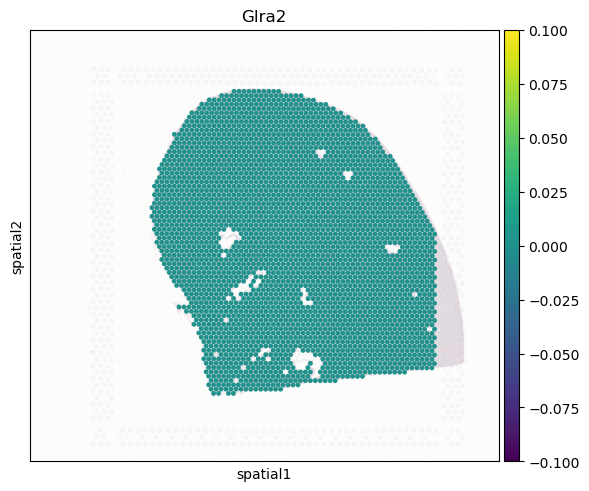

In [34]:
sq.pl.spatial_scatter(
    adata,
    size=1.5,
    color='Glra2',
    alpha=1,
    img_alpha=.2,
)

We can now generalize the principle of spatial autocorrelation to bi- and multivariate analyses, and use different statistics to measure the autocorrelation.

## Global Measures for Bivariate Data
### Global Bivariate Moran’s 

For two continous variables the global bivariate Moran’s $I$ is defined as

$
I_B = 
\frac{\sum_i (\sum_j w_{ij}y_j \times x_i)}{\sum_i x_i^2}
$
(Wartenberg 1985; Bivand 2022)

where $x_i$ and $y_j$ are the two variables of interest and $w_{ij}$ is the value of the spatial weights matrix for positions $i$ and $j$.

The global bivariate Moran’s $I$ is a measure of correlation between the variables $x$ and $y$ where $y$ has a spatial lag. The result might overestimate the spatial autocorrelation of the variables due to the non-spatial correlation of $x$ and $y$ (Bivand 2022).

In [35]:
np.random.seed(49)

moran_bv = Moran_BV(
    adata[:, features[0]].X.toarray(),
    adata[:, features[1]].X.toarray(),
    spatial_weights,
    transformation="r",
    permutations=499,
)

In [36]:
print(f"The global Moran's I for the genes {features[0]} and {features[1]} is {moran_bv.I.round(4)} with a permutation p-value of {moran_bv.p_sim}.")

The global Moran's I for the genes Slc5a12 and Calr is 0.2663 with a permutation p-value of 0.002.


In [37]:
adata.uns[f"moran_bv_{features[0]}_{features[1]}"] = moran_bv.I
adata.uns[f"moran_bv_{features[0]}_{features[1]}_p_sim"] = moran_bv.p_sim

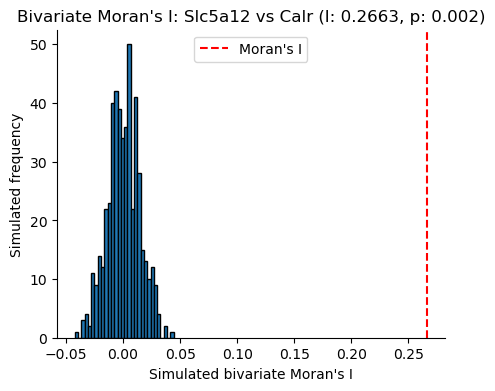

In [38]:
plt.figure(figsize=(5, 4))
hist = plt.hist(moran_bv.sim, bins=30, edgecolor="black")
plt.axvline(moran_bv.I, color="red", linestyle="--", label="Moran's I")
plt.xlabel("Simulated bivariate Moran's I")
plt.ylabel("Simulated frequency")
plt.title(f"Bivariate Moran's I: {features[0]} vs {features[1]} (I: {moran_bv.I.round(4)}, p: {moran_bv.p_sim.round(4)})")
plt.legend(loc='upper center')
sns.despine()

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
    The global bivariate Moran’s $I$ quantifies whether high (or low) values of one variable tend to occur spatially near high (or low) values of another variable across the entire tissue.
</div>
</div>

### Global Bivariate Lee's $L$

Lee’s $L$ is a bivariate measure that combines non-spatial pearson correlation with spatial autocorrelation via Moran’s $I$ [@leeDevelopingBivariateSpatial2001]. This enables us to asses the spatial dependence of two continuous variables in a single measure. The measure is defined as

$$L(x,y) = \frac{n}{\sum_{i=1}^n(\sum_{j=1}^nw_{ij})^2}\frac{\sum_{i=1}^n[\sum_{j=1}^nw_{ij}(x_j-\bar{x})](\sum_{j=1}^nw_{ij}(y_j-\bar{y}))}{\sqrt{\sum_{i=1}^n(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^n(y_i-\bar{y})^2}}$$

where $w_{ij}$ is the value of the spatial weights matrix for positions $i$ and $j$, $x$ and $y$, the two variables of interest and $\bar{x}$ and $\bar{y}$ their means [@leeDevelopingBivariateSpatial2001 ;@bivandPackagesAnalyzingSpatial2022]. 


In [39]:
np.random.seed(49)
lees_l_estimator = Spatial_Pearson(connectivity=spatial_weights.to_sparse(), permutations=499)
lees_l_estimator.fit(
    adata[:, features[0]].X.toarray(),
    adata[:, features[1]].X.toarray(),
)

Spatial_Pearson(connectivity=<COOrdinate sparse array of dtype 'float64'
	with 18018 stored elements and shape (3123, 3123)>,
                permutations=499)

In [40]:
lees_l_estimator.association_

array([[0.61092273, 0.26807996],
       [0.26807996, 0.39910281]])

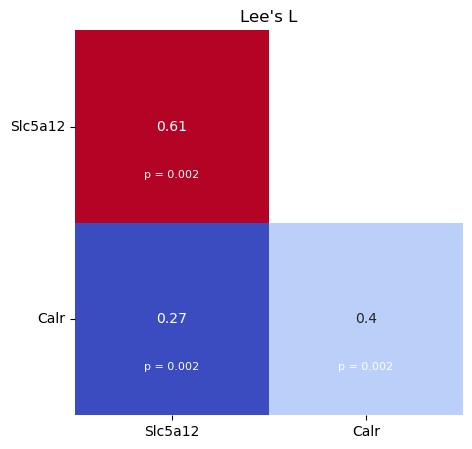

In [41]:
adata.uns[f"lees_l_{features[0]}_{features[1]}"] = lees_l_estimator.association_
adata.uns[f"lees_l_{features[0]}_{features[1]}_p_sim"] = lees_l_estimator.significance_

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    lees_l_estimator.association_,
    cmap='coolwarm',
    annot=True,
    cbar=False,
    ax=ax,
    mask=np.triu(np.ones_like(lees_l_estimator.association_)) - np.eye(2),
)
ax.set_title("Lee's L")
ax.set_xticklabels(features[:2])
ax.set_yticklabels(features[:2], rotation=0)

for i, row in enumerate(lees_l_estimator.significance_):
    for j, p in enumerate(row):
        ax.text(j + 0.5, i + 0.75, f"p = {p:.3f}", ha="center", va="center", color="white", fontsize=8)

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
    Across the whole tissue, do regions with high values of variable $x$ tend to coincide spatially with regions of high (or low) values of variable $y$?
</div>
</div>

<div style="
  padding: 10px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
<div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>
  <div style="margin-top: 8px;">
  What is the difference between global univariate Moran’s I and global univariate Lee’s L?</p>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
  <strong>Moran’s I</strong> measures spatial autocorrelation as a normalized spatial covariance between a variable and its spatial lag. It behaves like the slope of a regression of the spatial lag on the original variable and depends on the spatial weights matrix.</p>

  <p><strong>Univariate Lee’s L</strong> measures spatial autocorrelation using a fully symmetric variance normalization, making it mathematically equivalent to a correlation coefficient between the variable and its spatially weighted counterpart.</p>

  <p><strong>Key difference:</strong><br>
  Moran’s I has a regression-style interpretation and its magnitude depends more directly on the weights matrix structure. Lee’s L has a correlation-style interpretation.</p>

  </details>
</div>

## Local Measures for Bivariate Data

### Local Bivariate Moran's $I$

Similar to the global bivariate Moran's $I$ statistic, there is a local analogue. The formula is given by:

$$
I_i^B = x_i\sum_jw_{ij}y_j
$$
(Anselin 2024; Bivand 2022).

This can be interesting in the context of detection of coexpressed ligand-receptor pairs. A method that is based on local bivariate Moran's $I$ and tries to detect such pairs is `SpatialDM` (Li et al. 2023).

In [42]:
local_moran_bv = Moran_Local_BV(
    adata[:, features[0]].X.toarray().astype(np.float64),
    adata[:, features[1]].X.toarray().astype(np.float64),
    spatial_weights,
    transformation="r",
    permutations=499,
    seed=49,
)

In [43]:
stat_key = f"local_moran_bv_{features[0]}_{features[1]}"
p_key = f"{stat_key}_p_sim"

# store in adata
adata.obs[stat_key] = local_moran_bv.Is
adata.obs[p_key] = local_moran_bv.p_sim

To see which spots actually show significant results, let's create a mask for spots with p-values below 0.05.

In [44]:
mask = adata.obs[p_key] < 0.05
adata.obs[f"{p_key}_sig"] = adata.obs[p_key].where(mask)

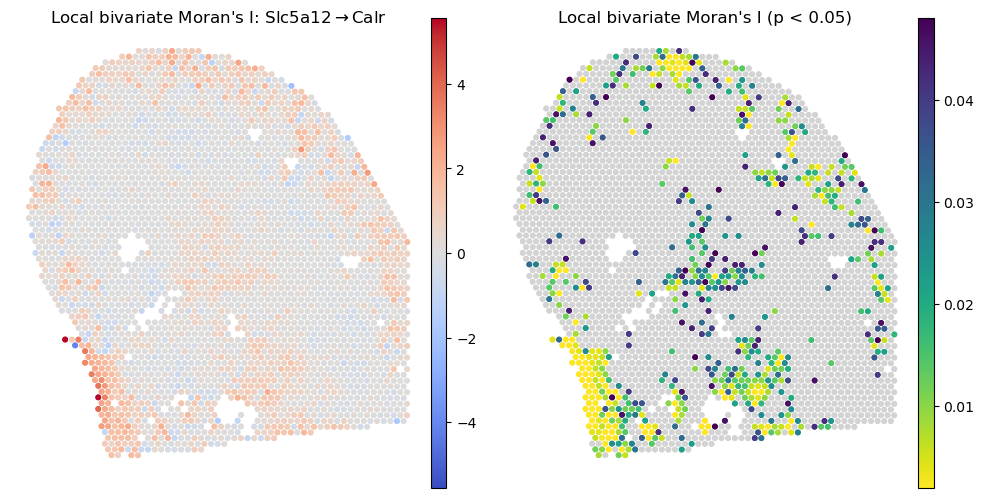

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), layout="tight")
sq.pl.spatial_scatter(
    adata,
    color=f"local_moran_bv_{features[0]}_{features[1]}",
    cmap='coolwarm',
    vmin=-adata.obs[f"local_moran_bv_{features[0]}_{features[1]}"].abs().max(),
    vmax=adata.obs[f"local_moran_bv_{features[0]}_{features[1]}"].abs().max(),
    vcenter=0,
    shape=None,
    library_id="spatial",
    title=f"Local bivariate Moran's I: {features[0]}"+ r"$\rightarrow$" + f"{features[1]}",
    ax=ax[0],
    fig=fig,
    size=40,
)
sq.pl.spatial_scatter(
    adata,
    color=f"{p_key}_sig",
    cmap="viridis_r",
    na_color="lightgrey",
    shape=None,
    library_id="spatial",
    title=f"Local bivariate Moran's I (p < 0.05)",
    ax=ax[1],
    fig=fig,
    size=40,
)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

To be able to interpret these results in a more biologically meaningful way, we can visualize them as a LISA quadrant map again to identify spatial clusters and outliers.

In [46]:
from libpysal.weights.spatial_lag import lag_spatial

x = adata[:, features[0]].X
y = adata[:, features[1]].X
x = x.toarray().ravel().astype(np.float64) if hasattr(x, "toarray") else np.asarray(x).ravel().astype(np.float64)
y = y.toarray().ravel().astype(np.float64) if hasattr(y, "toarray") else np.asarray(y).ravel().astype(np.float64)

# z-score (mean-center + scale)
zx = (x - x.mean()) / (x.std(ddof=1) + 1e-12)
zy = (y - y.mean()) / (y.std(ddof=1) + 1e-12)

# spatial lag of spot i = expression around spot i
lag_zy = lag_spatial(spatial_weights, zy)

stat_key = f"local_moran_bv_{features[0]}_{features[1]}"
p_key = f"{stat_key}_p_sim"

sig = adata.obs[p_key].to_numpy() < 0.05

# Quadrants based on signs of zx and lag_zy
quad = np.full(adata.n_obs, "NS", dtype=object)
quad[sig & (zx > 0) & (lag_zy > 0)] = "HH"
quad[sig & (zx > 0) & (lag_zy < 0)] = "HL"
quad[sig & (zx < 0) & (lag_zy > 0)] = "LH"
quad[sig & (zx < 0) & (lag_zy < 0)] = "LL"

quad_key = f"{stat_key}_quad"
adata.obs[quad_key] = pd.Categorical(quad, categories=["HH", "HL", "LH", "LL", "NS"], ordered=True)

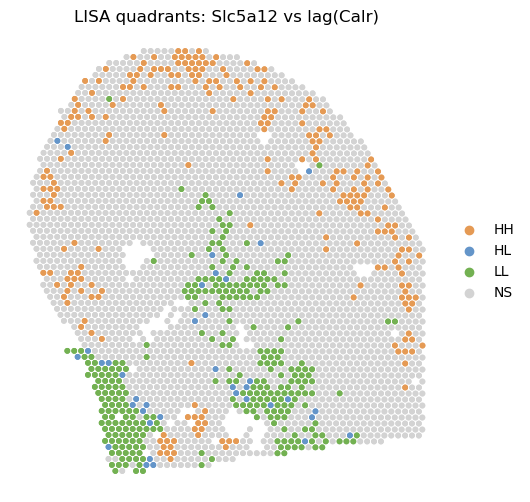

In [47]:
cmap_quads = ListedColormap(["#e59a54", "#6495c9", "#73b152", "lightgrey"])  # HH, HL, LL, NS

quad3_key = f"{quad_key}_HH_HL_LL"
q = adata.obs[quad_key].astype(str).copy()
q[~q.isin(["HH", "HL", "LL"])] = "NS"
adata.obs[quad3_key] = pd.Categorical(q, categories=["HH", "HL", "LL", "NS"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 6))
sq.pl.spatial_scatter(
    adata,
    color=quad3_key,
    palette=cmap_quads,
    shape=None,
    library_id="spatial",
    title=f"LISA quadrants: {features[0]} vs lag({features[1]})",
    ax=ax,
    size=40,
)
ax.set_axis_off()
plt.show()

<div style="
  padding: 10px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
<div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>
  <div style="margin-top: 8px;">
<div>
    <ol>
         <li>Why do we omit the LH group?</li>
        <li>Create a plot where you also display the LH group.</li>
    </ol>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
Both HL and LH represent negative local spatial autocorrelation (local spatial discordance). We are not displaying LH because it represents the mirror case of HL (a low-value outlier in a high-value region), and depending on the biological question, we may choose to focus on high-expression hotspots and high-value outliers.
  </details>
</div>

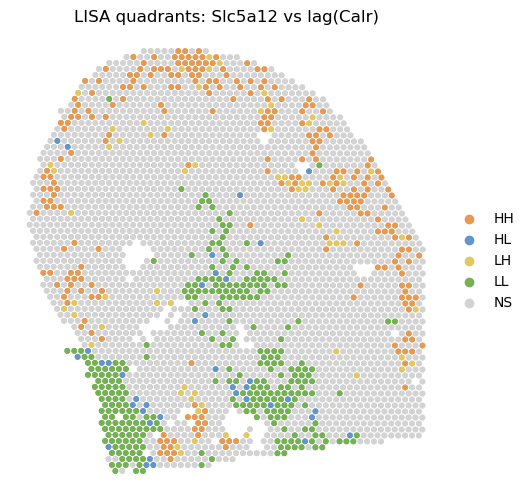

In [48]:
cmap_quads = ListedColormap(["#e59a54", "#6495c9", "#e3c763", "#73b152", "lightgrey"])  # HH, HL, LH, LL, NS

fig, ax = plt.subplots(figsize=(6, 6))
sq.pl.spatial_scatter(
    adata,
    color=quad_key,
    palette=cmap_quads,
    shape=None,
    library_id="spatial",
    title=f"LISA quadrants: {features[0]} vs lag({features[1]})",
    ax=ax,
    size=40,
)
ax.set_axis_off()
plt.show()

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
LISA quadrants classify each spatial location (spot) based on:

1.	the value of a variable at that spot, and
2.	the value of the spatial lag (neighborhood average) of the same or another variable.

So they answer the question:
Is this spot similar to its neighbors, or an outlier relative to them?

In the bivariate case:
Is gene $x$ at this spot high or low relative to the expression of gene $y$ in the surrounding neighborhood?

**HH - High-High**
A spot with high expression of x is surrounded by neighbors with high expression of y. Indicates shared niches or co-regulated programs.

**HL - High-Low**
A spot with high x is surrounded by neighbors with low y. Often marks interfaces, transitions, or invasion fronts.

**LH - Low-High**
A spot with low x is surrounded by neighbors with high y.

**LL - Low-Low**
A spot with low x is surrounded by neighbors with low y.
</div>
</div>

### Local Bivariate Lee's $L$

Similar to the global variant of Lee's $L$ the local variant [@leeDevelopingBivariateSpatial2001 ;@bivandPackagesAnalyzingSpatial2022] is defined as 

$$L_i(x,y) = \frac{n(\sum_{j=1}^nw_{ij}(x_j-\bar{x}))(\sum_{j=1}^nw_{ij}(y_j-\bar{y}))}{\sqrt{\sum_{i=1}^n(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^n(y_i-\bar{y})^2}}$$

Local Lee's $L$ is a measure of spatial co-expression, when the variables of interest are gene expression measurements. Unlike the gobal version, the variables are not averaged and show the local contribution to the metric. Positive values indicate colocalization, negative values indicate segregation [@leeDevelopingBivariateSpatial2001 ;@bivandPackagesAnalyzingSpatial2022].

In [49]:
np.random.seed(49)
local_lees_l_estimator = Spatial_Pearson_Local(connectivity=spatial_weights.to_sparse(), permutations=499)
local_lees_l_estimator.fit(
    adata[:, features[0]].X.toarray().astype(np.float64),
    adata[:, features[1]].X.toarray().astype(np.float64),
)

Spatial_Pearson_Local(connectivity=<COOrdinate sparse array of dtype 'float64'
	with 18018 stored elements and shape (3123, 3123)>,
                      permutations=499)

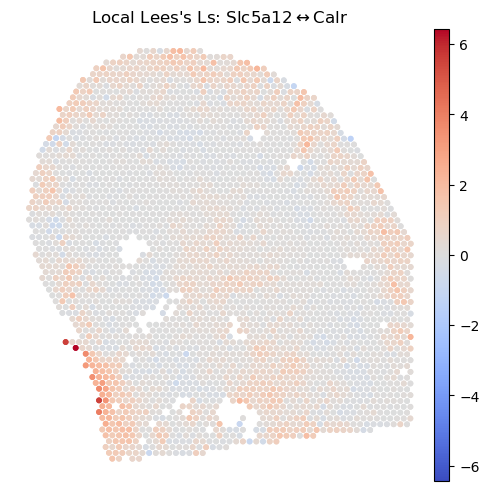

In [50]:
adata.obs[f"local_lees_l_{features[0]}_{features[1]}"] = local_lees_l_estimator.associations_

fig, ax = plt.subplots(1, 1, figsize=(5,5), layout = "tight")
sq.pl.spatial_scatter(
    adata,
    color=f"local_lees_l_{features[0]}_{features[1]}",
    cmap='coolwarm',
    vmin=-adata.obs[f"local_lees_l_{features[0]}_{features[1]}"].abs().max(),
    vmax=adata.obs[f"local_lees_l_{features[0]}_{features[1]}"].abs().max(),
    vcenter=0,
    shape=None,
    library_id="spatial",
    title=f"Local Lees's Ls: {features[0]}" + r"$\leftrightarrow$" + f"{features[1]}",
    ax=ax,
    fig=fig,
    size=40,
)
ax.set_axis_off()

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
Local bivariate Lee’s L quantifies whether high (or low) expression of one gene around a spot spatially co-occurs with high (or low) expression of another gene around that same spot. It is a local spatial co-expression statistic.
</div>
</div>

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🪞 Reflection</div>
  <div>
    Can you explain the difference between the global bivariate Moran's $I$ and Lee's $L$?
  </div>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
  <p><strong>Bivariate Moran’s I</strong> measures whether values of one variable at a location are associated with neighboring values of another variable. It is asymmetrically normalized (only by the variance of one variable) and is not strictly bounded between −1 and 1. It behaves like a spatial regression slope.</p>
  <p><strong>Lee’s L</strong> measures spatial cross-correlation between two variables in a symmetric and variance-normalized way. It is bounded (approximately between −1 and 1) and behaves like a spatial correlation coefficient.</p>
  <p><strong>In short:</strong> Moran’s I answers whether one variable predicts the spatial lag of another, while Lee’s L measures how strongly two variables co-vary across space in a properly normalized way.</p>
  </details>
</div>

## Local Measures for Multivariate Data

### Multivariate local Geary's $C$

Geary’s $C$ is a measure of spatial autocorrelation that is based on the difference between a variable and its neighbours. (Anselin 2019, 1995) defines it as

$$C_i = \sum_{j=1}^n w_{ij}(x_i-y_j)^2$$

and can be generalized to $k$ features (in our case genes) by expanding 

$$C_{k,i} = \sum_{v=1}^k C_{v,i}$$

where $c_{v,i}$ is the local Geary’s $C$ for the $v$th variable at location $i$. The number of variables that can be used is not fixed, which makes the interpretation a bit more difficult. In general, the metric summarizes similarity in the "multivariate attribute space" (i.e. the gene expression) to its geographic neighbours. The common difficulty in these analyses is the interpretation of the mixture of similarity in the physical space and similarity in the attribute space (Anselin 2019, 1995). 


To speed up computation we will use highly variable genes.

In [51]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor="seurat_v3", inplace=True)

In [52]:
local_geary_mv_estimator = Geary_Local_MV(connectivity=spatial_weights, permutations=100)
local_geary_mv_estimator.fit(
    [
        adata[:, highly_variable_gene].X.toarray()[:, 0]
        for highly_variable_gene in adata.var_names[adata.var["highly_variable"]].to_list()
    ]
)

Geary_Local_MV(connectivity=<libpysal.weights.weights.W object at 0x7f3e216558d0>,
               permutations=100)

In [53]:
adata.obs["local_geary_mv"] = local_geary_mv_estimator.localG
adata.obs["local_geary_mv_p"] = -np.log10(false_discovery_control(local_geary_mv_estimator.p_sim))

We can further plot the results of the permutation test. Significant values indicate interesting regions, but should be interpreted with care for various reasons. For example, we are looking for similarity in a combination of multiple features but the exact combination is not known. Anselin (2019) write “Overall, however, the statistic indicates a combination of the notion of distance in multi-attribute space with that of geographic neighbors. This is the essence of any spatial autocorrelation statistic. It is also the trade-off encountered in spatially constrained multivariate clustering methods (for a recent discussion, see, e.g., Grubesic, Wei, and Murray 2014)”. Multi-attribute space refers here to the highly variable genes. The problem can be summarised to where the similarity comes from, the gene expression or the physical space (Anselin 2019). The same problem is common in spatial domain detection methods.

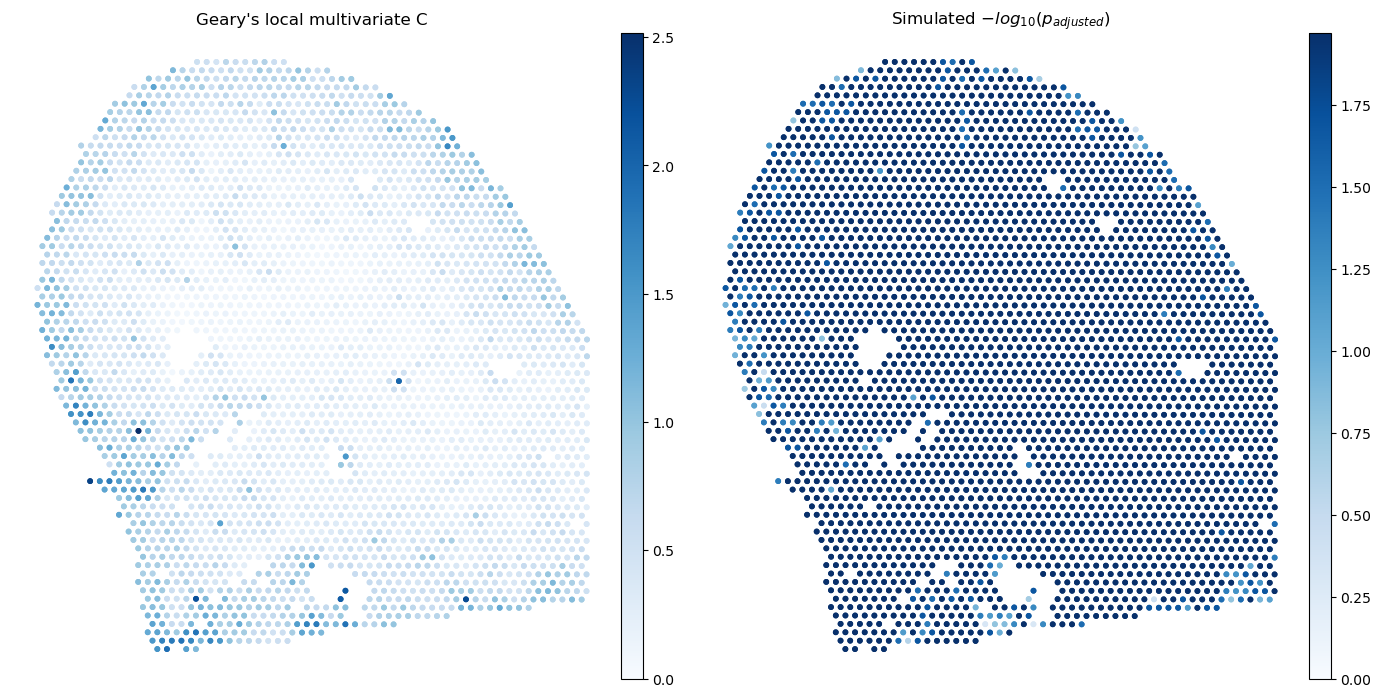

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(len(features)*7, 7), layout = "tight")
sq.pl.spatial_scatter(
    adata,
    color=["local_geary_mv", "local_geary_mv_p"],
    cmap="Blues",
    vmin=0,
    shape=None,
    library_id="spatial",
    title=["Geary's local multivariate C", "Simulated $-log_{10}(p_{adjusted})$"],
    ax=ax,
    fig=fig,
    size=40
)
for ax in ax:
    ax.set_axis_off()

Plotted are the effect size and the adjusted p-values in space.

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
Local multivariate Geary’s C quantifies how different a spot’s multigene expression profile is from the profiles of its immediate spatial neighbors.
Think of each spot as a point in high-dimensional expression space (e.g. HVGs, pathways, gene pairs).

For a given spot $i$, the multivariate local Geary’s C asks:

Are my neighbors transcriptionally similar to me, or very different — considering all variables jointly?

So it compares:
- Spot $i$’s expression vector
- Expression vectors of its spatial neighbors
- Weighted by the spatial adjacency graph
</div>
</div>

## Local Neighbour Match Test

This test is useful to assess the overlap of the $k$-nearest neighbours from physical distances (tissue space) with the $k$-nearest neighbours from the gene expression measurements (attribute space). $k$-nearest neighbour matrices are computed for both tissue and attribute space. In a second step the probability of overlap between the two matrices is computed (Anselin and Li 2020). 

In [55]:
k = 20

# Spatial grid neighbors
df_neighbors_spatial = spatial_weights.to_adjlist() # build adjacency (edge) list
df_neighbors_features = KNN(KDTree(adata[:, adata.var["highly_variable"]].X.toarray(), distance_metric="euclidean"), k=k).to_adjlist()

focal_points = sorted(set(df_neighbors_spatial.focal).intersection(df_neighbors_features.focal))
focal_points_names = adata.obs_names[focal_points]

df_neighborhood_match_test = pd.DataFrame(columns=["neighbors_match_count", "neighbors_match_fraction"], index=focal_points_names)

# adjlist.focal returns the source node index (spot id)
# adjlist[index].neighbor returns a list of neighbors of the given node
for focal_point, focal_name in zip(focal_points, focal_points_names):
    neighbors_spatial = set(df_neighbors_spatial[df_neighbors_spatial.focal == focal_point].neighbor)
    neighbors_features = set(df_neighbors_features[df_neighbors_features.focal == focal_point].neighbor)
    neighbors_match_count = len(neighbors_spatial.intersection(neighbors_features))
    neighbors_match_fraction = neighbors_match_count / len(neighbors_spatial)
    df_neighborhood_match_test.loc[focal_name] = [neighbors_match_count, neighbors_match_fraction]

adata.obs["neighbors_match_count"] = df_neighborhood_match_test.loc[adata.obs_names, "neighbors_match_count"]
adata.obs["neighbors_match_fraction"] = df_neighborhood_match_test.loc[adata.obs_names, "neighbors_match_fraction"]

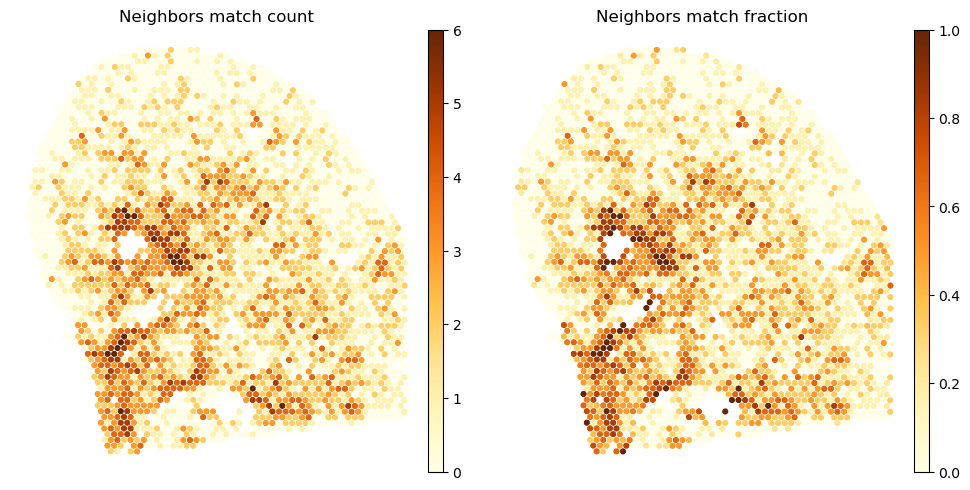

In [56]:
# plot the results
neighborhood_match_test_features = ["neighbors_match_count", "neighbors_match_fraction"]
fig, axes = plt.subplots(1, len(neighborhood_match_test_features), figsize=(len(neighborhood_match_test_features)*5, 5), layout="tight")
for feature, ax in zip(neighborhood_match_test_features, axes):
    title = feature.replace("_", " ").capitalize()
    sq.pl.spatial_scatter(adata,
    color=feature, 
    shape=None, 
    size=40, 
    cmap="YlOrBr", 
    title=title, 
    ax=ax, 
    fig=fig,
    use_raw=False)
    ax.set_axis_off()

Cardinality is a measure of how many neighbours of the two matrices are common. Some regions show high cardinality with low probability and therefore share similarity in both attribute and physical space. In contrast to multivariate local Geary’s $C$ this metric focuses directly on the distances and not on a weighted average. A problem of this approach is called the empty space problem which states that as the number of dimensions of the feature sets increase, the empty space between observations also increases (Anselin and Li 2020).

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
    
**High values:**
<ul>
    <li>Nearby spots share similar transcriptional programs</li>
    <li>Tissue organization is locally coherent</li>
</ul>

**Low values:**
<ul>
    <li>Nearby spots are transcriptionally different</li>
    <li>Local mixing, boundaries, gradients, or technical artifacts</li>
</ul>
</div>
</div>

## Measures for binary and categorical data

### Join count statistic

In addition to measures of spatial autocorrelation for continuous data as seen above, the join count statistic method applies the same concept to binary and categorical data. In essence, the joint count statistic compares the distribution of categorical marks (variables) in a lattice with frequencies that would occur randomly. These random occurrences can be computed using a theoretical approximation or random permutations. The same concept was also extended in a multivariate setting with more than two categories.

First, we need to get categorical marks for each data point. We do so by running (non-spatial) PCA on the data followed by Leiden clustering (Traag, Waltman, and Van Eck 2019). 

In [57]:
np.random.seed(123)

# compute a PCA on the 
sc.pp.pca(adata, n_comps=50, zero_center=True, svd_solver="arpack")

# compute the neighbours
sc.pp.neighbors(adata, use_rep="X_pca", knn=True, n_pcs=10)

# compute leiden clustering
sc.tl.leiden(adata, resolution=0.3, flavor="igraph", objective_function="modularity")

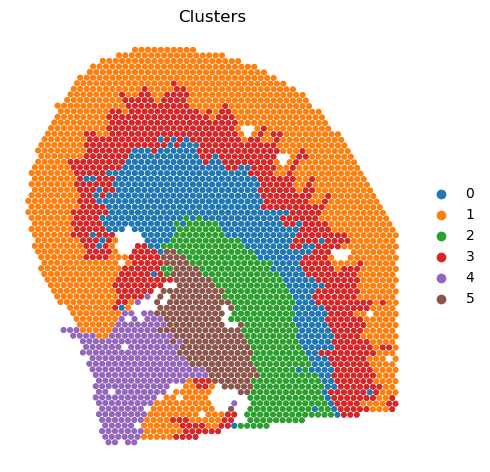

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), layout="tight")
sq.pl.spatial_scatter(
    adata,
    color="leiden",
    shape=None,
    library_id="spatial",
    title="Clusters",
    ax=ax,
    fig=fig,
    size=40
)
ax.set_axis_off()

Let's compute the join count statistics for this example:

In [59]:
from scipy import sparse

# adjacency / connectivities
C = sparse.csr_matrix(adata.obsp["spatial_connectivities"]).astype(bool)

# take each undirected edge once
C_u = sparse.triu(C, k=1).tocoo()
rows, cols = C_u.row, C_u.col

labels = adata.obs["leiden"].astype("category")
cats = labels.cat.categories
codes = labels.cat.codes.to_numpy()
K = len(cats)

def join_counts_undirected(codes_):
    # count each undirected edge once into an upper-tri matrix in label space
    J = np.zeros((K, K), dtype=float)
    a = codes_[rows]
    b = codes_[cols]
    # enforce (min,max) so joins always land in upper triangle of label space
    lo = np.minimum(a, b)
    hi = np.maximum(a, b)
    for i, j in zip(lo, hi):
        J[i, j] += 1
    return J

# Observed
O_obs_upper = join_counts_undirected(codes)
df_obs = pd.DataFrame(O_obs_upper, index=cats, columns=cats)
df_obs

0       1      2       3      4      5
0  1237.0     2.0  130.0   313.0    1.0    2.0
1     0.0  2830.0    0.0   483.0   40.0    1.0
2     0.0     0.0  984.0     6.0    0.0   72.0
3     0.0     0.0    0.0  1655.0   10.0   10.0
4     0.0     0.0    0.0     0.0  651.0   44.0
5     0.0     0.0    0.0     0.0    0.0  538.0

The rows show different combinations of clusters that are in physical contact. E.g. the cell (0,0) contains the join statistic for cluster 0 with itself, cell (0,1) for cluster 0 with cluster 1, etc.

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🪞 Reflection</div>
  <div>
    Can you explain what the numbers on the diagonal of the join count matrix represent?
  </div>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
The numbers on the <strong>diagonal</strong> of a join count matrix represent the number of spatial neighbor pairs where <strong>both locations belong to the same category</strong>. In other words, they count how often a category is adjacent to itself (e.g., cluster A next to cluster A). Large diagonal values indicate strong within-group spatial clustering.
  </details>
</div>

Let's now visualize these proximity measures as an interaction network graph.

In [60]:
import networkx as nx

# df_obs: upper-tri join counts
# cats: cluster names

edges = []
for i_idx, i in enumerate(cats):
    for j_idx, j in enumerate(cats):
        if j_idx <= i_idx:
            continue
        w = float(df_obs.loc[i, j])
        if w > 0:
            edges.append((i, j, {"joins": w}))

In [61]:
# build the graph
G = nx.Graph()
n = adata.obs["leiden"].value_counts()
for c in cats:
    G.add_node(c, n_spots=int(n[c]))
G.add_edges_from(edges)
print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

nodes: 6 edges: 13


In [62]:
# get cluster size
counts = pd.Series(codes).value_counts().sort_index()
n = pd.Series(counts.values, index=cats)

In [63]:
pos = nx.circular_layout(G)

joins = np.array([G.edges[e]["joins"] for e in G.edges], dtype=float)
# scale widths to avoid 1 huge edge dominating
edge_widths = 0.5 + 6.0 * (joins / (np.percentile(joins, 95) + 1e-9))
edge_widths = np.clip(edge_widths, 0.5, 8.0)

# node size by cluster size
node_sizes = [G.nodes[v]["n_spots"] for v in G.nodes]
# scale for plotting
node_sizes = np.array(node_sizes, dtype=float)
node_sizes = 200 + 1800 * (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min() + 1e-9)

In [64]:
# get cluster colors
clusters = adata.obs["leiden"].astype("category").cat.categories
cluster_colors = adata.uns["leiden_colors"]
cluster_color_map = dict(zip(clusters, cluster_colors))

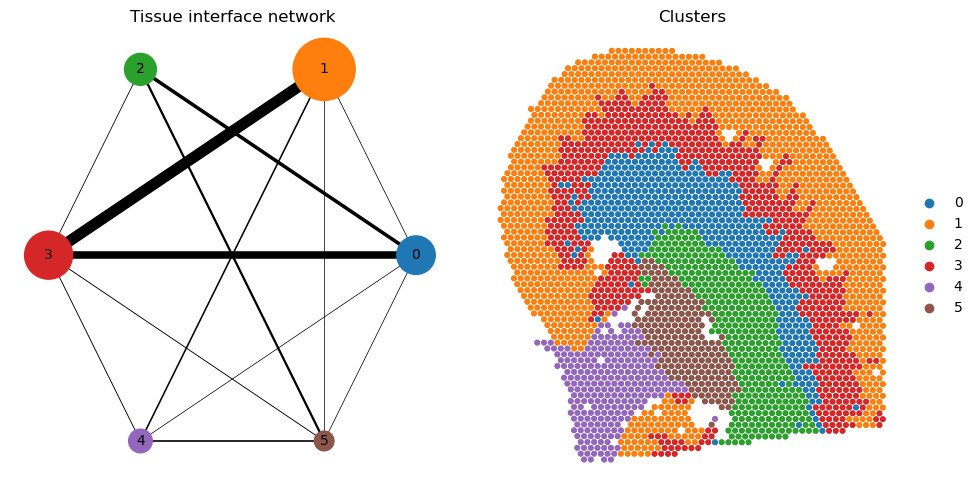

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), layout="tight")

node_colors = [cluster_color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    ax=ax[0]
)
nx.draw_networkx_labels(G, pos, font_size=10, ax=ax[0])
nx.draw_networkx_edges(G, pos, width=edge_widths, ax=ax[0])
ax[0].set_title("Tissue interface network")

sq.pl.spatial_scatter(
    adata,
    color="leiden",
    shape=None,
    library_id="spatial",
    title="Clusters",
    ax=ax[1],
    fig=fig,
    size=40
)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

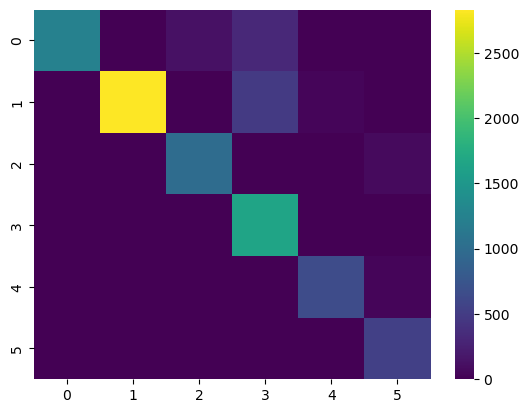

In [66]:
# And the same in heatmap form
fig, ax = plt.subplots()
sns.heatmap(df_obs, cmap='viridis')
plt.show()

Squidpy provides an implementation of the join count statistic, which they call interaction matrix. Note that they do not account for the symmetry in the data, meaning they count each undirected interaction twice, whereas our matrix counts each edge in the neighborhood graph only once.

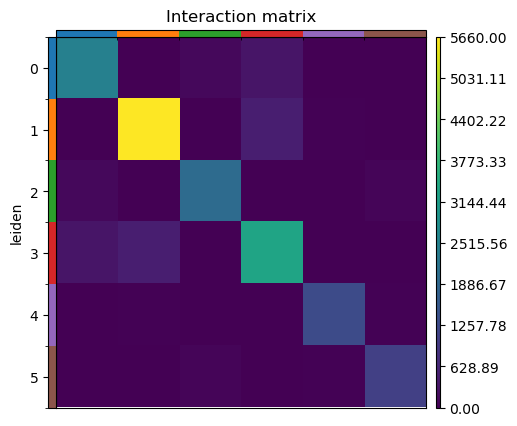

In [67]:
sq.gr.interaction_matrix(adata, cluster_key="leiden")
sq.pl.interaction_matrix(adata, cluster_key="leiden", method=None, annotate=False, figsize=(4, 4))

Squidpy however also implements a permutation test to calculate an expectation matrix (representing a random distribution of our clusters in space), that can than be compared to our observation matrix, resulting in a neighborhood enrichment score.

If spots belonging to two different clusters are often found in spatial proximity, then they will have a high neighborhood enrichment score and can be defined as being enriched. On the other hand, if they are far apart, and therefore are seldom a neighborhood, the score will be low and they can be defined as depleted.

100%|██████████| 1000/1000 [00:00<00:00, 3247.80/s]


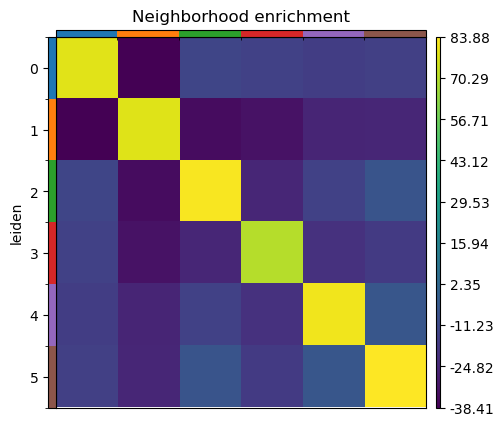

In [68]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(adata, cluster_key="leiden")

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<div>
    
**High within-cluster joins**
- Compact, spatially continuous tissue domains (e.g. tumor core, epithelial layers)

**Low within-cluster joins**
- Scattered or transitional cell states (e.g. infiltrating immune cells, cycling populations)

**High between-cluster joins**
- Extensive physical interfaces (e.g. tumor–stroma, immune infiltration zones)

**Low between-cluster joins**
- Spatial separation or compartmentalization (e.g. distinct anatomical regions)
</div>
</div>

### Cluster co-occurance accross spatial dimensions

The co-occurrence score is defined as: $\frac{p(exp|cond)}{p(exp)}$

where $p(exp|cond)$ is the conditional probability of observing a cluster $\exp$ conditioned on the presence of a cluster $cond$, whereas $p(exp)$ is the probability of observing $\exp$ in the radius size of interest. The score is computed across increasing radii size around each observation (i.e. spots here) in the tissue.

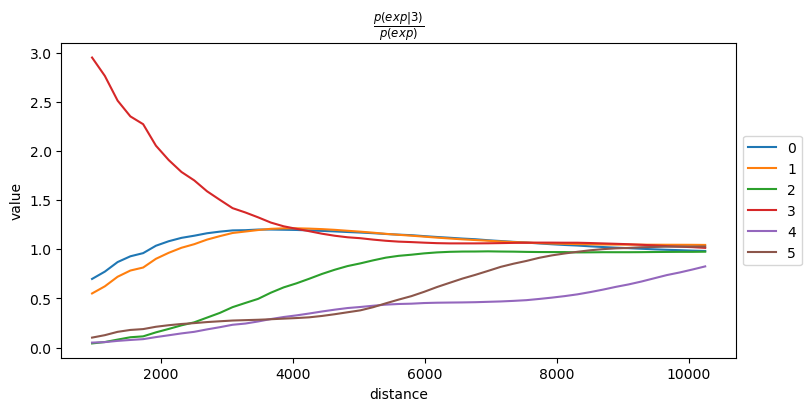

In [72]:
sq.gr.co_occurrence(adata, cluster_key="leiden")
sq.pl.co_occurrence(
    adata,
    cluster_key="leiden",
    clusters="3",
    figsize=(8,4),
)

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🪞 Reflection</div>
  <div>
    At what distance do other clusters co-occur with cluster 3?
  </div>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
    Cluster 3 begins to co-occur with clusters 0 and 1 at a distance of about 4000um.
    </div>
</div>

Similarly to the co-occurance of clusters, you can for example calculate image features on the data and measure their co-occurance.

<a id="spatial-statistics-references"></a>

## 📚 Further Reading

### Core Spatial Statistics Theory

- **Zuur, A., Ieno, E., Smith, G.** (2007). *Analyzing Ecological Data*.   
  https://doi.org/10.1007/978-0-387-45972-1 (Weight matrices, graphs, everything)

- **Moran, P. A. P.** (1950). *Notes on continuous stochastic phenomena*.  
  https://doi.org/10.2307/2332142
  (Classic paper introducing Moran’s I)

- **Anselin, L.** (1995). “Local Indicators of Spatial Association—LISA.” *Geographical Analysis* 27(2):93–115.  
  https://doi.org/10.1111/j.1538-4632.1995.tb00338.x

- **Anselin, L.** (2019). “A Local Indicator of Multivariate Spatial Association: Extending Geary’s C.” *Geographical Analysis* 51(2):133–150.  
  https://doi.org/10.1111/gean.12164

- **Getis, A.** (2009). “Spatial Weights Matrices.” *Geographical Analysis* 41:404–410.  
  https://doi.org/10.1111/j.1538-4632.2009.00768.x

- **Cressie, N. A. C.** (1993). *Statistics for Spatial Data*, Revised Edition. Wiley.  
  https://doi.org/10.1002/9781119115151

### Point Pattern & Lattice Data Analysis

- **Baddeley, A., Rubak, E., & Turner, R.** (2015). *Spatial Point Patterns: Methodology and Applications with R*. CRC Press.  
  https://doi.org/10.1201/b19708

- **Baddeley, A. & Turner, R.** (2005). “Spatstat: An R Package for Analyzing Spatial Point Patterns.” *Journal of Statistical Software* 12(6):1–42.  
  https://doi.org/10.18637/jss.v012.i06

- **Pebesma, E. & Bivand, R.** (2023). *Spatial Data Science: With Applications in R*. CRC Press.  
  https://doi.org/10.1201/9780429459016

- **Ripley, B. D.** (1976). “The Second-Order Analysis of Stationary Point Processes.” *Journal of Applied Probability* 13:255–266.  
  https://doi.org/10.2307/3212829

### Spatial Omics Applications & Methods

- **Emons, M., Gunz, S., Crowell, H. L., Mallona, I., Furrer, R., & Robinson, M. D.** (2025). “Harnessing the Potential of Spatial Statistics for Spatial Omics Data with pasta.” *Nucleic Acids Research* 53(17).  
  https://doi.org/10.1093/nar/gkaf870

- **Janesick, A., Shelansky, R., Gottscho, A. D., Wagner, F., Williams, S. R., Rouault, M., Beliakoff, G., et al.** (2023). “High Resolution Mapping of the Tumor Microenvironment Using Integrated Single-Cell, Spatial and In Situ Analysis.” *Nature Communications* 14(8353).  
  https://doi.org/10.1038/s41467-023-43458-x

- **Moses, L., Einarsson, P. H., Jackson, K., Luebbert, L., Booeshaghi, A. S., Antonsson, S., Bray, N., Melsted, P., & Pachter, L.** (2023). “Voyager: Exploratory Single-Cell Genomics Data Analysis with Geospatial Statistics.” *bioRxiv*.  
  https://doi.org/10.1101/2023.07.20.549945